In [ ]:
#Importo il modulo drive, fornito da Colab, per interagire con Google Drive.
from google.colab import drive
#Monta il mio Google Drive nella directory locale /content/drive del runtime, con la garanzia che sia in uno stato "pulito".
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
global_var = {
    # PARAMETRI DI CARICAMENTO / PREPROCESSING DEI DATI:
    "batch_size": 192,          #Dimensione batch (A100 regge 192 a seq_len=1024).
    "n_workers": 8,             #Processi del DataLoader per pre-caricare i batch (I/O più fluido).
    "max_seq_len": 1024,        #Lunghezza massima in token: troncamento/padding a 1024.

    # PARAMETRI DEL MODELLO (Transformer):
    "embedding_dim": 256,       #Dimensione degli embedding e dei canali del Transformer.
    "n_layers": 6,              #Numero di blocchi Transformer (profondità del modello).
    "n_heads": 8,               #Teste di attenzione --> 256/8=32 dim per head.
    "ff_dim": 1024,             #Dim del feed-forward interno.
    "dropout": 0.10,            #Dropout moderato (dataset ampio; regolarizzazione senza underfit).
    "output_dim": 2,            #Numero classi: 0=HUMAN, 1=GenAI (logits K=2).

    # PARAMETRI DI TRAINING:
    "learning_rate": 2e-4,      #LR base (pensato per scheduler con warmup).
    "epochs": 8,                #Epoche massime di addestramento.
    "weight_decay": 0.01,       #Regolarizzazione L2 in AdamW (decoupled weight decay).
    "label_smoothing": 0.05,    #Smussamento etichette (migliora calibrazione/confidenza).
    "grad_clip": 1.0,           #Clipping L2 della norma del gradiente (stabilità).

    # PARAMETRI DI VALIDAZIONE/REGOLARIZZAZIONE (per early stopping):
    "val_size": 0.2,            #Frazione del train riservata alla validation (20%).
    "patience": 4,              #Early stopping: stop se non vi è nessun miglioramento per 4 epoche.
    "min_delta": 1e-4,          #Miglioramento minimo richiesto su val-loss per azzerare la pazienza.

    # PARAMETRI PER LO SCHEDULER (warmup e cosine):
    "warmup_ratio": 0.06,       #Percentuale di step totali in warmup (~6%), prima del decadimento coseno.
}

In [ ]:
# Deve stare PRIMA di qualunque import di torch / modello / training
import os
os.environ["TORCHINDUCTOR_CUDAGRAPHS"] = "0"
os.environ["TORCH_USE_CUDAGRAPHS"] = "0"     # doppia cintura
# opzionale: niente ricompile caching aggressivo
os.environ["TORCH_COMPILE_DEBUG"] = "0"

print("[BOOT] CUDAGraphs disabilitati per TorchInductor.")

[BOOT] CUDAGraphs disabilitati per TorchInductor.


In [ ]:
# STANDARD LIBRARY (Python):
import os                        #Gestione percorsi, variabili d'ambiente, I/O di base.
import math                      #Funzioni matematiche (p.es. ceil, log, sqrt).
import copy                      #Copie profonde/superficiali di oggetti complessi (es. pesi modello).
import re                        #Espressioni regolari per pulizia e parsing dei testi.
import random                    #RNG standard (per seed e sampling semplice).
from collections import Counter  #Conteggi frequenze di token/etichette.

# CALCOLO NUMERICO / DATI TABELLARI:
import numpy as np               #Tensori/array N-dim, operazioni numeriche vettorizzate.
import pandas as pd              #Tabelle, CSV/Parquet, join/filter/groupby.

# VISUALIZZAZIONE:
import matplotlib.pyplot as plt  #Grafici 2D (linee, barre, scatter, heatmap via imshow).
import seaborn as sns            #Wrapper statistico su Matplotlib (stile + funzioni comode).

# PROGRESS BAR (notebook-friendly):
from tqdm.notebook import tqdm   #Barra di avanzamento per loop su batch/epoche.

# PyTorch (core + dataset + mixed precision):
import torch                                              #Tensori e operazioni su CPU/GPU; gestione device.
import torch.nn as nn                                     #Moduli di rete (Linear, Dropout, ReLU, etc).
import torch.nn.functional as F                           #Funzioni funzionali (relu, cross_entropy, log_softmax, etc).
from torch.utils.data import Dataset, DataLoader, Subset  #API per dataset custom e mini-batch.
from torch.cuda import amp                                #Per AMP.
from torch.cuda.amp import autocast, GradScaler           #AMP: mixed precision e scaler.

# Scikit-learn (split + metriche):
from sklearn.model_selection import train_test_split      #Split train/val/test stratificato.
from sklearn.metrics import (
    accuracy_score,                                       #Accuratezza: (TP+TN)/totale;
    balanced_accuracy_score,                              #Media delle recall per classe;
    f1_score,                                             #F1 = 2·(precision·recall)/(precision+recall);
    precision_recall_fscore_support,                      #Precision, recall, fscore per classe e macro/micro;
    confusion_matrix,                                     #Matrice di confusione (TP/TN/FP/FN per classe);
    classification_report,                                 #Report testuale riassuntivo per classe e aggregati.
    recall_score
)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"[LOG] Device → {device}")

if device.type == "cuda":
    name = torch.cuda.get_device_name(0)
    cap  = torch.cuda.get_device_capability(0)
    print(f"[LOG] CUDA device → {name}, compute capability={cap}")

    # TF32 per matmul (A100)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision('high')

    # Forza SDPA --> FlashAttention quando possibile
    try:
        # Use the new API if available
        from torch.nn.attention import sdpa_kernel
        torch.backends.cuda.enable_flash_sdp(True)
        torch.backends.cuda.enable_math_sdp(False)
        torch.backends.cuda.enable_mem_efficient_sdp(True)
    except ImportError:
        # Fallback to the old API if the new one is not available
        torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False, enable_mem_efficient=True)


    # Usa BF16 su A100 (altrimenti FP16)
    BF16_OK = hasattr(torch.cuda, "is_bf16_supported") and torch.cuda.is_bf16_supported()
    AMP_DTYPE = torch.bfloat16 if (cap[0] >= 8 and BF16_OK) else torch.float16
    USE_BF16  = (AMP_DTYPE == torch.bfloat16)
else:
    AMP_DTYPE = torch.float32
    USE_BF16  = False

[LOG] Device → cuda:0
[LOG] CUDA device → NVIDIA A100-SXM4-80GB, compute capability=(8, 0)


In [ ]:
def collate_trim(batch):
    """
    Collate function per DataLoader.
    Input: batch = lista di tuple (x, y), con x tensore 1D di token ID (padded con 0) e y etichetta.
    Output: (xs_trim, ys) con xs_trim di shape [B, L_batch] dove L_batch = max lunghezza reale nel batch.
    Assunzione: PAD == 0 e non viene usato come token "valido".
    """
    xs, ys = zip(*batch)  #Unpack: xs = sequenze, ys = etichette; xs è una tupla di tensori 1D [T_max].

    #Lunghezza reale per sequenza: conta i token != 0 (cioè non PAD).
    lens = [int((x != 0).sum().item()) for x in xs]

    #Evita edge case L_batch = 0 se tutte le sequenze sono vuote; garantisce almeno 1.
    maxlen = max(1, max(lens)) if lens else 1

    #Taglia ogni sequenza alla lunghezza massima del batch: riduce compute/memoria.
    xs_trim = torch.stack([x[:maxlen] for x in xs])  # Shape [B, maxlen]

    #Stack delle etichette in un tensore 1D di shape [B]
    ys = torch.stack(ys)

    return xs_trim, ys

def make_loader(dataset, batch_size, shuffle):
    """
    Costruisce un DataLoader "veloce":
      - usa collate_trim per dynamic padding/trimming per-batch;
      - pin_memory su CUDA per velocizzare i transfer CPU→GPU (.to(device, non_blocking=True));
      - se n_workers > 0: worker persistenti + prefetch di più batch.
    """
    kwargs = {}
    if global_var["n_workers"] > 0:
        kwargs["persistent_workers"] = True   #Evita teardown/respawn dei worker ad ogni epoca.
        kwargs["prefetch_factor"] = 6        #Ogni worker pre-carica N batch (default=2); 6 = più aggressivo su A100.
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=global_var["n_workers"],
        pin_memory=(device.type == "cuda"),   #Consigliato su CUDA; innocuo su CPU.
        collate_fn=collate_trim,              #Applica il trimming dinamico definito sopra.
        **kwargs
    )

In [ ]:
# --- HOLDOUT per VALIDATION + TEST fisso (EN → IT test) -------------------------------
SEED = 42
BASE = "/content/drive/MyDrive/TESI-Classificazione/MIO"   # attenzione: TESI-Classificazione
os.makedirs(BASE, exist_ok=True)

TRAIN_CSV_ORIG = f"{BASE}/en_train_full.csv"
DEV_CSV_ORIG   = f"{BASE}/en_dev_full.csv"

VAL_CSV        = f"{BASE}/en_val_holdout.csv"      # VALIDATION = parte del DEV
TEST_CSV       = f"{BASE}/it_dev_full.csv"         # TEST fisso (italiano, ~1843 righe)

# Carica i dataset
df_train = pd.read_csv(TRAIN_CSV_ORIG)
df_dev   = pd.read_csv(DEV_CSV_ORIG)
assert "label" in df_train.columns and "label" in df_dev.columns, "Manca 'label' nei CSV."

# Usa tutto il DEV come validation
df_val = df_dev.copy()

# Reset index e salva
df_val = df_val.reset_index(drop=True)
df_val.to_csv(VAL_CSV, index=False)

print(f"[LOG] TRAIN: {len(df_train)} | DEV: {len(df_dev)} | VAL: {len(df_val)} | TEST fisso: {len(pd.read_csv(TEST_CSV))}")
print("[LOG] VAL label:",  df_val["label"].value_counts().sort_index().to_dict())
print("[LOG] TEST label:", pd.read_csv(TEST_CSV)["label"].value_counts().sort_index().to_dict())

[LOG] TRAIN: 610676 | DEV: 261849 | VAL: 261849 | TEST fisso: 1843
[LOG] VAL label: {0: 98041, 1: 163808}
[LOG] TEST label: {1: 1843}


In [ ]:
PAD, UNK, CLS = "<pad>", "<unk>", "<cls>"               #Token speciali riservati: padding (<pad>), fuori-vocabolario (<unk), inizio-sequenza (<cls>).
_token_re = re.compile(r"\b\w+\b", flags=re.UNICODE)    #Regex: cattura sequenze alfanumeriche (token).

def basic_tokenizer(text: str):
    return _token_re.findall(text.lower())            #Tokenizza testo lowercased --> lista di token.

def build_vocab(text_iter, min_freq: int = 1):
    counter = Counter()                               #Contatore di frequenze.
    for line in text_iter:                            #Itera sulle frasi del dataset.
        counter.update(basic_tokenizer(line))         #Aggiorna conteggio token.
    vocab = {PAD:0, UNK:1, CLS:2}                     #Inizializza vocabolario con ID riservati.
    for tok, c in counter.most_common():              #Ordina token per frequenza.
        if c >= min_freq and tok not in vocab:        #Inserisci solo se frequenza >= soglia e non riservato.
            vocab[tok] = len(vocab)                   #Assegna ID progressivo.
    return vocab                                      #Ritorna mapping token-->ID.

class TextDataset(Dataset):
    def __init__(self, csv_path: str, vocab: dict | None = None, preencode: bool = True):
        df = pd.read_csv(csv_path)
        self.texts  = df["text"].astype(str).tolist()
        self.labels = df["label"].astype(int).tolist()
        self.vocab  = vocab or build_vocab(self.texts)

        self.preencode = preencode
        if preencode:
            # Pre-encode una sola volta (veloce alle epoche successive)
            self.x = [self.encode(t) for t in self.texts]
            # lunghezze reali (per bucketing)
            self.lengths = [int((xi != 0).sum().item()) for xi in self.x]
        else:
            self.x = None
            self.lengths = None

    def __len__(self): return len(self.labels)

    def encode(self, text: str):
        toks = basic_tokenizer(text)
        ids = [self.vocab.get(t, self.vocab[UNK]) for t in toks][: max(0, global_var["max_seq_len"]-1)]
        ids = [self.vocab[CLS]] + ids
        pad_len = global_var["max_seq_len"] - len(ids)
        if pad_len > 0:
            ids += [self.vocab[PAD]] * pad_len
        return torch.tensor(ids, dtype=torch.long)

    def __getitem__(self, idx):
        x = self.x[idx] if self.preencode else self.encode(self.texts[idx])
        return x, torch.tensor(self.labels[idx])

In [ ]:
class BucketBatchSampler(torch.utils.data.Sampler):
    def __init__(self, lengths, batch_size, shuffle=True, bucket_size=4096, seed=42):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.rng = np.random.default_rng(seed)

        order = np.argsort(lengths)  # corto→lungo
        # Suddividi in bucket; shuffle dentro il bucket per varietà ma lunghezze simili
        buckets = [order[i:i+bucket_size] for i in range(0, len(order), bucket_size)]
        if shuffle:
            for b in buckets: self.rng.shuffle(b)
            self.rng.shuffle(buckets)
        order = np.concatenate(buckets)

        # Costruisci i batch
        self.batches = [order[i:i+batch_size] for i in range(0, len(order), batch_size)]

    def __iter__(self):
        if self.shuffle:
            self.rng.shuffle(self.batches)
        for b in self.batches:
            yield b.tolist()

    def __len__(self):
        return len(self.batches)

def make_loader(dataset, batch_size, shuffle):
    # worker più alti su A100
    nw = max(4, global_var.get("n_workers", 4))
    kwargs = dict(
        num_workers=nw,
        pin_memory=(device.type == "cuda"),
        pin_memory_device="cuda" if device.type == "cuda" else "",
        persistent_workers=(nw > 0)
    )

    # Se il dataset ha pre-encode + lengths → usa BucketBatchSampler
    if getattr(dataset, "lengths", None) is not None:
        bs = BucketBatchSampler(dataset.lengths, batch_size=batch_size, shuffle=shuffle, bucket_size=batch_size*32)
        return DataLoader(dataset, batch_sampler=bs, collate_fn=collate_trim, prefetch_factor=8, **kwargs)

    # fallback: standard
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_trim,
        prefetch_factor=8,
        **kwargs
    )

In [ ]:
def seed_everything(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

# --- DATASET & DATALOADER ----------------------------------------------------
seed_everything(42)

# vocab SOLO dal TRAIN
train_ds = TextDataset(TRAIN_CSV_ORIG)       # costruisce il vocab
vocab    = train_ds.vocab

val_ds   = TextDataset(VAL_CSV,  vocab=vocab)   # resto del DEV
test_ds  = TextDataset(TEST_CSV, vocab=vocab)

train_loader = make_loader(train_ds, global_var["batch_size"], shuffle=True)
val_loader   = make_loader(val_ds,  global_var["batch_size"], shuffle=False)
test_loader  = make_loader(test_ds, global_var["batch_size"], shuffle=False)

print("[CHECK] train/val/test =", len(train_ds), len(val_ds), len(test_ds))

[CHECK] train/val/test = 610676 261849 1843


In [ ]:
class DepthwiseSeparableConv(nn.Module):
    """Blocco base MobileNet (Depthwise + Pointwise)."""
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1, p_drop=0.1):
        super().__init__()
        self.depthwise = nn.Conv1d(in_ch, in_ch, kernel_size,
                                   stride=stride, padding=padding, groups=in_ch, bias=False)
        self.pointwise = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(p_drop)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        x = self.act(x)
        return self.drop(x)


class MobileNetTextClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, out_dim=2, p_drop=0.1):
        super().__init__()
        # Embedding token
        self.tok_emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)

        # CNN backbone (3 blocchi MobileNet)
        self.conv1 = DepthwiseSeparableConv(emb_dim, 128, kernel_size=5, p_drop=p_drop)
        self.conv2 = DepthwiseSeparableConv(128, 256, kernel_size=5, p_drop=p_drop)
        self.conv3 = DepthwiseSeparableConv(256, 256, kernel_size=3, p_drop=p_drop)

        # Classifier
        self.fc = nn.Linear(512, out_dim)   # concat(mean_pool, max_pool)

    def forward(self, x):
        # x: [B, T]
        emb = self.tok_emb(x)               # [B, T, emb_dim]
        h = emb.transpose(1, 2)             # [B, emb_dim, T] per convoluzioni

        h = self.conv1(h)
        h = self.conv2(h)
        h = self.conv3(h)

        # Global pooling
        avg_pool = h.mean(dim=2)            # [B, C]
        max_pool, _ = h.max(dim=2)          # [B, C]
        feat = torch.cat([avg_pool, max_pool], dim=1)  # [B, 2C]

        return self.fc(feat)

# --- MODELLO CNN MOBILE NET TEXT CLASSIFIER -----------------
model = MobileNetTextClassifier(
    vocab_size=len(vocab),
    emb_dim=global_var["embedding_dim"],   # puoi tenere 128 o 256
    out_dim=global_var["output_dim"],
    p_drop=global_var["dropout"]
).to(device)

print("[LOG] Modello MobileNet CNN creato.")

[LOG] Modello MobileNet CNN creato.


In [ ]:
# =========[ LOSS / OPT / SCHEDULER / TRAIN ]==================================

# --- Pesi di classe dal TRAIN COMPLETO ---------------------------------------
y_train = np.array(train_ds.labels)
from collections import Counter
cnt = Counter(y_train)
tot = int(sum(cnt.values()))
n0, n1 = int(cnt.get(0, 0)), int(cnt.get(1, 0))

if n0 == 0 or n1 == 0:
    print("[LOG] Una classe è assente → niente class weights")
    class_weights = None
else:
    import numpy as np
    w0, w1 = np.clip([tot / max(1, n0), tot / max(1, n1)], 0.5, 5.0)
    class_weights = torch.tensor([w0, w1], dtype=torch.float, device=device)
    print(f"[LOG] Class weights (clipped): w0={w0:.3f}, w1={w1:.3f}")

loss_fn = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=global_var["label_smoothing"]
)

adamw_kwargs = dict(lr=global_var["learning_rate"], weight_decay=global_var["weight_decay"])
try:
    optimizer = torch.optim.AdamW(model.parameters(), fused=True, **adamw_kwargs)
except TypeError:
    optimizer = torch.optim.AdamW(model.parameters(), **adamw_kwargs)

steps_per_epoch = max(1, len(train_loader))
total_steps     = steps_per_epoch * global_var["epochs"]
warmup_steps    = max(1, int(global_var["warmup_ratio"] * total_steps))

def lr_lambda(step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    prog = float(step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * prog)))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# AMP dtype (BF16 su A100; FP16 altrove)
if device.type == "cuda":
    cap_major = torch.cuda.get_device_capability(0)[0]
    bf16_ok   = hasattr(torch.cuda, "is_bf16_supported") and torch.cuda.is_bf16_supported()
    AMP_DTYPE = torch.bfloat16 if (cap_major >= 8 and bf16_ok) else torch.float16
    USE_BF16  = (AMP_DTYPE == torch.bfloat16)
else:
    AMP_DTYPE = torch.float32
    USE_BF16  = False

def train_amp_with_valcurve(model, train_loader, val_loader, epochs):
    """Allena su TRAIN; a fine epoca valuta la VAL (solo logging)."""
    use_cuda   = (device.type == "cuda")
    use_scaler = use_cuda and (not USE_BF16)
    # ✅ API corretta (niente argomento 'cuda' deprecato)
    scaler     = torch.cuda.amp.GradScaler(enabled=use_scaler)

    history = {"train": [], "val": []}

    for ep in range(epochs):
        # -------- TRAIN --------
        model.train()
        running = 0.0
        from tqdm.notebook import tqdm
        pbar = tqdm(train_loader, unit="batch", desc=f"Epoch {ep+1}/{epochs} [train]")

        for bx, by in pbar:
            bx = bx.to(device, non_blocking=True)
            by = by.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            # ✅ autocast corretto: passiamo device_type come stringa e dtype
            with torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=use_cuda):
                logits = model(bx)
                loss   = loss_fn(logits, by)

            if use_scaler:
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), global_var["grad_clip"])
                scaler.step(optimizer); scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), global_var["grad_clip"])
                optimizer.step()

            scheduler.step()

            # ✅ logging senza toccare i grad
            running += loss.detach().item()
            pbar.set_postfix(loss=running/(pbar.n+1), lr=scheduler.get_last_lr()[0])

        train_loss = running / max(1, len(train_loader))
        history["train"].append(train_loss)

        # -------- VAL (solo logging) --------
        model.eval()
        val_running = 0.0
        with torch.inference_mode(), torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=use_cuda):
            for bx, by in val_loader:
                bx = bx.to(device, non_blocking=True)
                by = by.to(device, non_blocking=True)
                vloss = loss_fn(model(bx), by).detach().item()
                val_running += vloss
        val_loss = val_running / max(1, len(val_loader))
        history["val"].append(val_loss)

        print(f"[LOG] Ep{ep+1}: train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

    return history

# --- Avvio training (con curva VAL) ------------------------------------------
history = train_amp_with_valcurve(model, train_loader, val_loader, global_var["epochs"])

[LOG] Class weights (clipped): w0=2.664, w1=1.601


/tmp/ipython-input-2394475225.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = torch.cuda.amp.GradScaler(enabled=use_scaler)


Epoch 1/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep1: train_loss=0.6303 | val_loss=0.5553


Epoch 2/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep2: train_loss=0.5163 | val_loss=0.5487


Epoch 3/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep3: train_loss=0.4613 | val_loss=0.4524


Epoch 4/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep4: train_loss=0.4257 | val_loss=0.4213


Epoch 5/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep5: train_loss=0.4015 | val_loss=0.4355


Epoch 6/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep6: train_loss=0.3853 | val_loss=0.4508


Epoch 7/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep7: train_loss=0.3764 | val_loss=0.4264


Epoch 8/8 [train]:   0%|          | 0/3181 [00:00<?, ?batch/s]

[LOG] Ep8: train_loss=0.3730 | val_loss=0.4377


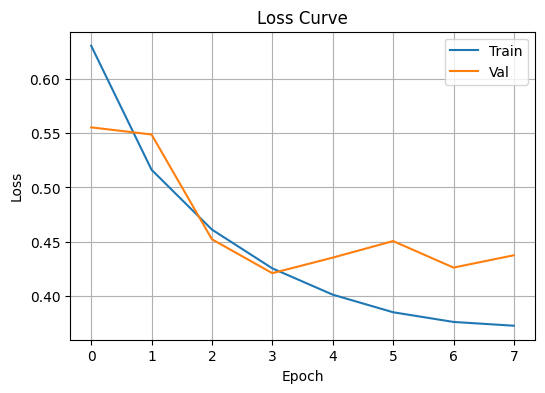

In [ ]:
plt.figure(figsize=(6,4))                                           #Crea una nuova figura 6x4 pollici.
plt.plot(history["train"], label="Train")                           #Traccia la curva della loss di training.
plt.plot(history["val"],   label="Val")                             #Traccia la curva della loss di validazione.
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve")    #Etichette degli assi X (epoche) e Y (loss) e titolo del grafico.
plt.legend(); plt.grid(True); plt.show()                            #Mostra la legenda (Train/Val), aggiunge la griglia per leggere meglio i valori e renderizza il grafico nella cella.

In [ ]:
# Se serve, si recupera il vocab da oggetti noti.
def extract_vocab(obj):
    seen = set()                                        #Traccia oggetti già visitati per evitare loop.
    while obj is not None and id(obj) not in seen:      #Risali lungo .dataset finché possibile.
        seen.add(id(obj))
        if hasattr(obj, "vocab"):                       #Se l'oggetto espone un attributo 'vocab' --> trovato.
            return obj.vocab
        obj = getattr(obj, "dataset", None)             #Altrimenti prova a risalire a .dataset (DataLoader/Subset).
    return None                                         #Fallback se non trovato.

base_vocab = None
#Si provano candidati globali più probabili (train_dataset --> full_train --> train_loader).
for cand in [globals().get("train_dataset"), globals().get("full_train"), globals().get("train_loader")]:
    if cand is not None:
        base_vocab = extract_vocab(cand)                #Tenta estrazione ricorsiva del vocab.
        if base_vocab is not None: break                #Stop appena trovato.
#Se ancora None, si prova il vocab globale.
if base_vocab is None and "vocab" in globals():
    base_vocab = vocab
#Ultimo fallback: si ricostruisce dal CSV di train (meno ideale ma robusto).
if base_vocab is None:
    base_vocab = TextDataset(TRAIN_CSV_ORIG).vocab
print(f"[LOG] Vocab OK (size={len(base_vocab):,}).")

def evaluate_loader(model, loader, label_names=("HUMAN","GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    model.eval()                                              #Modalità eval (niente dropout/bn).
    y_true, y_pred = [], []
    with torch.inference_mode():                              #Disabilita grad per velocità/memoria.
        for bx, by in loader:
            logits = model(bx.to(device)) / temperature       #Logits scalati con T.
            if threshold is None:                         #Caso 1: decisione argmax (multiclasse).
                pred = logits.argmax(1).cpu().numpy()
            else:                                         #Caso 2: soglia binaria sulla probabilità della classe 1.
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = (p1 >= threshold).astype(int)
            y_pred.extend(pred); y_true.extend(by.cpu().numpy())

    labels_fixed = [0, 1]                                     #Ordine etichette fisso per report/CM.
    report = classification_report(                           #Report strutturato (dict) con metriche per classe e macro.
        y_true, y_pred, labels=labels_fixed,
        target_names=list(label_names),
        output_dict=True, digits=4, zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=labels_fixed)      #Matrice di confusione.

    if plot_cm:                                         #Visualizzazione opzionale della CM.
        plt.figure(figsize=(5,4))
        tick_labels = [label_names[i] for i in labels_fixed]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=tick_labels, yticklabels=tick_labels, cbar=False)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm                                   #Ritorna metriche e CM.

def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN","GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    batch_size = batch_size or global_var["batch_size"]           #Batch di default da config globale.
    ds = TextDataset(csv_path, vocab=vocab)                       #Dataset dal CSV, forzando il vocab di train.
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)    #DataLoader con dynamic padding.
    rep, cm = evaluate_loader(                                    #Valuta sul loader.
        model, dl, label_names=label_names,
        temperature=temperature, threshold=threshold,
        plot_cm=plot_cm, title_suffix=title_suffix
    )
    return rep, cm, len(ds)                                       #Restituisce anche il numero di esempi.

[LOG] Vocab OK (size=574,882).


/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


[VAL] temperatura ottima T=1.289
[VAL] target=balanced_accuracy → t*=0.350 | bal_acc=0.857 | f1_macro=0.843


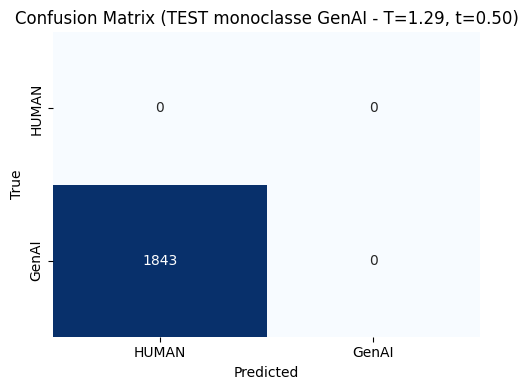


[LOG] Evaluation su TEST — campioni: 1843
Accuracy (=Recall GenAI): 0.0000
Precision (GenAI): 0.0000
Recall (GenAI): 0.0000
[INFO] Prime 30 righe (errori in alto). Il file completo viene salvato su Drive.



,id,text,true,pred,prob_genai_it,correct
384,b2393e1b-20d2-456b-b861-a3923f10ca46,"Il Crac Ambrosiano, l'ultimo scippo è stato un evento storico che ha avuto luogo a Milano nel 1628. È considerato una delle più grandi truffe finanziarie di...",GenAI,HUMAN,"47,48%",✗
1338,2ba38ebe-d264-46f3-a755-0fe8b80ff873,"Centinaia di migranti in fuga dalla Siria e dall’Afghanistan hanno trasformato l’isola greca di Kos, nel Mar Egeo, in un inferno disgustoso"". A rivelare l'a...",GenAI,HUMAN,"44,30%",✗
399,d87bc2a7-b604-4706-9e43-c80d05910e74,"Le elezioni comunali di Chivasso sono state condizionate dalla presenza della 'ndrangheta, la potente organizzazione criminale italiana che ha radici profon...",GenAI,HUMAN,"37,85%",✗
342,fa9ff8a0-7c0c-4b91-953a-94fff20f05eb,"RomaRigore e compassione, rispetto delle regole senza deludere le aspettative dei malati. Sull'intricata questione Stamina, con il via libera ad una sperime...",GenAI,HUMAN,"30,38%",✗
1639,237d6f4b-4bcc-486e-848c-8c230be800d0,Le cronache locali ci restituiscono un altro episodio di giovanissimi intossicati da un uso improprio dello spray al peperoncino . Questa mattina in un isti...,GenAI,HUMAN,"29,29%",✗
176,87464e5a-0632-4caf-8093-a4884faa83bb,"Dodici brigate saranno impegnate, in Iraq, nell'offensiva via terra contro i jihadisti sunniti dell'Isis. L'attacco partità nelle prossime settimane e sarà ...",GenAI,HUMAN,"28,27%",✗
1358,6e33c04a-aa88-47f7-ad4e-06d579810ffc,"Sono stati una coppia nelal fiction e forse avrebbero voluto esserelo anche nella realtà. Di certo lui, Niccolò Centioni si era preso una cotta per Micol Ol...",GenAI,HUMAN,"27,64%",✗
1597,6aeead6d-d47b-4f76-b2f1-47f2f2b3e628,"Un ghanese di 35 anni, residente a Conegliano e in Italia dal 2002, è stato arrestato giovedì pomeriggio per resistenza a pubblico ufficiale, danneggiamento...",GenAI,HUMAN,"26,58%",✗
239,18f1868c-aa80-449c-adc6-dd9956147cf8,Il Manchester United di Louis Van Gaal non sta sicuramente attraversando uno dei periodi più felici della sua storia: il club che sei anni fa fu campione d'...,GenAI,HUMAN,"26,27%",✗
493,10dfaa60-619f-49f8-a110-2f7e64b205a2,Come se niente fosse. I ministri del Nuovo centrodestra hanno sfilato davanti ai flash dei fotografi e agli obiettivi dei cineoperatori per mettere il cappe...,GenAI,HUMAN,"25,96%",✗


[LOG] File predizioni TEST salvato in: /content/drive/MyDrive/TESI-Classificazione/MIO/predictions_TEST_en_T1.29_t0.50.csv | righe: 1843


In [ ]:
def calibrate_temperature(model, val_loader, device):
    model.eval()
    logits_list, labels_list = [], []
    with torch.inference_mode():
        for bx, by in val_loader:
            logits_list.append(model(bx.to(device)))
            labels_list.append(by.to(device))
    logits = torch.cat(logits_list)
    labels = torch.cat(labels_list)

    nll = nn.CrossEntropyLoss()
    logT = torch.tensor(0.0, device=device, requires_grad=True)
    optT = torch.optim.LBFGS([logT], lr=0.5, max_iter=50)

    def closure():
        optT.zero_grad()
        T = torch.exp(logT)
        loss = nll(logits / T, labels)
        loss.backward()
        return loss

    optT.step(closure)
    T = torch.exp(logT).item()
    print(f"[VAL] temperatura ottima T={T:.3f}")
    return T

def tune_threshold_on_val(model, val_loader, device, temperature=1.0,
                          metric="balanced_accuracy", beta=1.1):
    model.eval()
    y_true, y_prob = [], []
    with torch.inference_mode():
        for bx, by in val_loader:
            p1 = torch.softmax(model(bx.to(device))/temperature, 1)[:,1].cpu().numpy()
            y_prob.extend(p1); y_true.extend(by.cpu().numpy())
    y_true = np.array(y_true); y_prob = np.array(y_prob)

    def score(y_hat):
        if metric == "balanced_accuracy":
            return balanced_accuracy_score(y_true, y_hat)
        if metric == "f1_macro":
            return f1_score(y_true, y_hat, average="macro", zero_division=0)
        return balanced_accuracy_score(y_true, y_hat)

    best_t, best_s = 0.5, -1
    for t in np.linspace(0.35, 0.75, 81):
        s = score((y_prob >= t).astype(int))
        if s > best_s: best_s, best_t = s, t

    y_hat = (y_prob >= best_t).astype(int)
    print(f"[VAL] target={metric} → t*={best_t:.3f} | "
          f"bal_acc={balanced_accuracy_score(y_true,y_hat):.3f} "
          f"| f1_macro={f1_score(y_true,y_hat,average='macro',zero_division=0):.3f}")
    return best_t

# Calibrazione
T      = calibrate_temperature(model, val_loader, device)
t_star = tune_threshold_on_val(model, val_loader, device, temperature=T)

# --- Evaluation su TEST monoclasse GenAI ---
rep_test, cm_test, n_test = evaluate_csv(
    model, TEST_CSV, vocab=vocab, label_names=("HUMAN","GenAI"),
    temperature=T, threshold=0.5, plot_cm=True,
    title_suffix=f"(TEST monoclasse GenAI - T={T:.2f}, t=0.50)"
)

assert cm_test.sum() == n_test, f"Non ho visto tutto il TEST: visti {cm_test.sum()} su {n_test}"
print(f"\n[LOG] Evaluation su TEST — campioni: {n_test}")

# Metriche sensate per dataset monoclasse (solo GenAI)
recall_genai = cm_test[1,1] / n_test if n_test>0 else 0.0
precision_genai = cm_test[1,1] / max(1, cm_test[:,1].sum())

print(f"Accuracy (=Recall GenAI): {recall_genai:.4f}")
print(f"Precision (GenAI): {precision_genai:.4f}")
print(f"Recall (GenAI): {recall_genai:.4f}")


# Tabella predizioni dettagliate sul TEST (monoclasse GenAI)
test_ds_for_csv = TextDataset(TEST_CSV, vocab=vocab)
test_dl = make_loader(test_ds_for_csv, global_var["batch_size"], shuffle=False)

probs, preds = [], []
model.eval()
with torch.inference_mode():
    for bx, _ in test_dl:
        # Get the probability of the GenAI class (index 1)
        p1 = F.softmax(model(bx.to(device))/T, dim=1)[:,1].cpu().numpy()
        probs.extend(p1.tolist())
        # Use a default threshold (e.g., 0.5) for binary prediction
        preds.extend((np.array(p1) >= 0.5).astype(int).tolist())

df_src = pd.read_csv(TEST_CSV)
df_out = pd.DataFrame({
    **({"id": df_src["id"]} if "id" in df_src.columns else {}),
    **({"topic": df_src["topic"]} if "topic" in df_src.columns else {}),
    "text": df_src["text"].astype(str),
    "true_id": df_src["label"].astype(int),
    "pred_id": np.array(preds, dtype=int),
    "prob_genai": np.array(probs, dtype=float)
})
map_lab = {0:"HUMAN", 1:"GenAI"}
df_out["true"] = df_out["true_id"].map(map_lab)
df_out["pred"] = df_out["pred_id"].map(map_lab)
df_out["prob_genai_pct"] = (df_out["prob_genai"]*100.0).round(2)
df_out["prob_genai_it"]  = df_out["prob_genai_pct"].map(lambda x: f"{x:.2f}%".replace('.',','))
df_out["correct"] = np.where(df_out["true_id"]==df_out["pred_id"], "✓", "✗")

# ordina: errors in alto, poi prob decrescente (within errors)
df_view = df_out.copy()
df_view["err_rank"] = (df_view["correct"]=="✓").astype(int)
# Sort by error rank (errors first), then by probability of GenAI (descending)
df_view = df_view.sort_values(["err_rank","prob_genai"], ascending=[True, False]).drop(columns=["err_rank"])

# Display and save
pd.set_option("display.max_colwidth", 160)
cols = [c for c in ["id","topic"] if c in df_view.columns] + ["text","true","pred","prob_genai_it","correct"]
print("[INFO] Prime 30 righe (errori in alto). Il file completo viene salvato su Drive.\n")
display(df_view[cols].head(30))

# salva con il default threshold in the filename
fname = f"predictions_TEST_en_T{T:.2f}_t{0.5:.2f}.csv"
save_path = os.path.join(BASE, fname)
df_view.to_csv(save_path, index=False, encoding="utf-8")
print("[LOG] File predizioni TEST salvato in:", save_path, "| righe:", len(df_view))

In [ ]:
# Se serve, si recupera il vocab da oggetti noti.
def extract_vocab(obj):
    seen = set()                                        #Traccia oggetti già visitati per evitare loop.
    while obj is not None and id(obj) not in seen:      #Risali lungo .dataset finché possibile.
        seen.add(id(obj))
        if hasattr(obj, "vocab"):                       #Se l'oggetto espone un attributo 'vocab' --> trovato.
            return obj.vocab
        obj = getattr(obj, "dataset", None)             #Altrimenti prova a risalire a .dataset (DataLoader/Subset).
    return None                                         #Fallback se non trovato.

# Si prova a recuperare il vocabolario dal dataset di train.
base_vocab = None
for cand in [globals().get("train_dataset"), globals().get("full_train"), globals().get("train_loader")]:
    if cand is not None:
        base_vocab = extract_vocab(cand)                #Tenta estrazione ricorsiva del vocab.
        if base_vocab is not None: break                #Stop appena trovato.
# Se ancora None, si prova il vocab globale.
if base_vocab is None and "vocab" in globals():
    base_vocab = vocab
# Ultimo fallback: si ricostruisce dal CSV di train (meno ideale ma robusto).
if base_vocab is None:
    base_vocab = TextDataset(TRAIN_CSV_ORIG).vocab
print(f"[LOG] Vocab OK (size={len(base_vocab):,}).")


def evaluate_loader(model, loader, label_names=("HUMAN","GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    model.eval()                                              #Modalità eval (niente dropout/bn).
    y_true, y_pred = [], []
    with torch.inference_mode():                              #Disabilita grad per velocità/memoria.
        for bx, by in loader:
            logits = model(bx.to(device)) / temperature       #Logits scalati con T.
            if threshold is None:                         #Caso 1: decisione argmax (multiclasse).
                pred = logits.argmax(1).cpu().numpy()
            else:                                         #Caso 2: soglia binaria sulla probabilità della classe 1.
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = (p1 >= threshold).astype(int)
            y_pred.extend(pred); y_true.extend(by.cpu().numpy())

    labels_fixed = [0, 1]                                     #Ordine etichette fisso per report/CM.
    report = classification_report(                           #Report strutturato (dict) con metriche per classe e macro.
        y_true, y_pred, labels=labels_fixed,
        target_names=list(label_names),
        output_dict=True, digits=4, zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=labels_fixed)      #Matrice di confusione.

    if plot_cm:                                         #Visualizzazione opzionale della CM.
        plt.figure(figsize=(5,4))
        tick_labels = [label_names[i] for i in labels_fixed]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=tick_labels, yticklabels=tick_labels, cbar=False)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm                                   #Ritorna metriche e CM.

def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN","GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    batch_size = batch_size or global_var["batch_size"]           #Batch di default da config globale.
    ds = TextDataset(csv_path, vocab=vocab)                       #Dataset dal CSV, forzando il vocab di train.
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)    #DataLoader con dynamic padding.
    rep, cm = evaluate_loader(                                    #Valuta sul loader.
        model, dl, label_names=label_names,
        temperature=temperature, threshold=threshold,
        plot_cm=plot_cm, title_suffix=title_suffix
    )
    return rep, cm, len(ds)                                       #Restituisce anche il numero di esempi.

[LOG] Vocab OK (size=574,882).


[LOG] VALIDATION: /content/drive/MyDrive/TESI-Classificazione/MIO/en_val_holdout.csv (261849 righe)
[LOG] Distribuzione label:
label
0     98041
1    163808


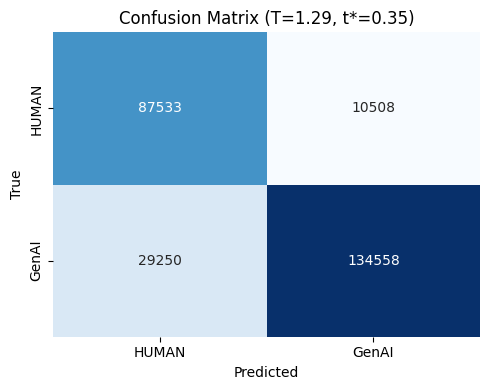


[LOG] Evaluation su VALIDATION — campioni: 261849
Accuracy: 0.8482  |  F1 macro: 0.8431  |  Precision macro: 0.8385  |  Recall macro: 0.8571


In [ ]:
# EVAL_CSV ≡ VALIDATION (resto del DEV)
EVAL_CSV = VAL_CSV
assert os.path.exists(EVAL_CSV)

# recupero vocab (se servisse)
base_vocab = vocab

df_eval = pd.read_csv(EVAL_CSV)
print(f"[LOG] VALIDATION: {EVAL_CSV} ({len(df_eval)} righe)")
print("[LOG] Distribuzione label:"); print(df_eval["label"].value_counts().sort_index().to_string())

rep_eval, cm_eval, n_eval = evaluate_csv(
    model, EVAL_CSV, vocab=base_vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T, threshold=t_star,
    plot_cm=True, title_suffix=f"(T={T:.2f}, t*={t_star:.2f})"
)
assert cm_eval.sum() == n_eval
print(f"\n[LOG] Evaluation su VALIDATION — campioni: {n_eval}")
print(f"Accuracy: {rep_eval['accuracy']:.4f}  |  F1 macro: {rep_eval['macro avg']['f1-score']:.4f}  "
      f"|  Precision macro: {rep_eval['macro avg']['precision']:.4f}  |  Recall macro: {rep_eval['macro avg']['recall']:.4f}")

In [ ]:
# Tabelle e CSV SOLO per il TEST fisso (monoclasse GenAI)
TEST_EVAL_CSV = TEST_CSV
assert os.path.exists(TEST_EVAL_CSV)

base_vocab = vocab
df_eval = pd.read_csv(TEST_EVAL_CSV)
print(f"[LOG] TEST_EVAL: {TEST_EVAL_CSV} ({len(df_eval)} righe)")
print("[LOG] Distribuzione label:"); print(df_eval["label"].value_counts().sort_index().to_string())

rep_eval, cm_eval, n_eval = evaluate_csv(
    model, TEST_EVAL_CSV, vocab=base_vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T, threshold=0.5,
    plot_cm=True, title_suffix=f"(TEST monoclasse GenAI - T={T:.2f}, t=0.50)"
)
assert cm_eval.sum() == n_eval

print(f"\n[LOG] Evaluation su TEST — campioni: {n_eval}")
recall_genai = cm_eval[1,1] / n_eval if n_eval>0 else 0.0
precision_genai = cm_eval[1,1] / max(1, cm_eval[:,1].sum())

print(f"Accuracy (=Recall GenAI): {recall_genai:.4f}")
print(f"Precision (GenAI): {precision_genai:.4f}")
print(f"Recall (GenAI): {recall_genai:.4f}")

In [ ]:
# Se serve, si recupera il vocab da oggetti noti.
def extract_vocab(obj):
    seen = set()                                        #Traccia oggetti già visitati per evitare loop.
    while obj is not None and id(obj) not in seen:      #Risali lungo .dataset finché possibile.
        seen.add(id(obj))
        if hasattr(obj, "vocab"):                       #Se l'oggetto espone un attributo 'vocab' --> trovato.
            return obj.vocab
        obj = getattr(obj, "dataset", None)             #Altrimenti prova a risalire a .dataset (DataLoader/Subset).
    return None                                         #Fallback se non trovato.

base_vocab = None
#Si provano candidati globali più probabili (train_dataset --> full_train --> train_loader).
for cand in [globals().get("train_dataset"), globals().get("full_train"), globals().get("train_loader")]:
    if cand is not None:
        base_vocab = extract_vocab(cand)                #Tenta estrazione ricorsiva del vocab.
        if base_vocab is not None: break                #Stop appena trovato.
#Se ancora None, si prova il vocab globale.
if base_vocab is None and "vocab" in globals():
    base_vocab = vocab
#Ultimo fallback: si ricostruisce dal CSV di train (meno ideale ma robusto).
if base_vocab is None:
    base_vocab = TextDataset(TRAIN_CSV_ORIG).vocab
print(f"[LOG] Vocab OK (size={len(base_vocab):,}).")

def evaluate_loader(model, loader, label_names=("HUMAN","GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    model.eval()                                              #Modalità eval (niente dropout/bn).
    y_true, y_pred = [], []
    with torch.inference_mode():                              #Disabilita grad per velocità/memoria.
        for bx, by in loader:
            logits = model(bx.to(device)) / temperature       #Logits scalati con T.
            if threshold is None:                         #Caso 1: decisione argmax (multiclasse).
                pred = logits.argmax(1).cpu().numpy()
            else:                                         #Caso 2: soglia binaria sulla probabilità della classe 1.
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = (p1 >= threshold).astype(int)
            y_pred.extend(pred); y_true.extend(by.cpu().numpy())

    labels_fixed = [0, 1]                                     #Ordine etichette fisso per report/CM.
    report = classification_report(                           #Report strutturato (dict) con metriche per classe e macro.
        y_true, y_pred, labels=labels_fixed,
        target_names=list(label_names),
        output_dict=True, digits=4, zero_division=0
    )
    cm = confusion_matrix(y_true, y_pred, labels=labels_fixed)      #Matrice di confusione.

    if plot_cm:                                         #Visualizzazione opzionale della CM.
        plt.figure(figsize=(5,4))
        tick_labels = [label_names[i] for i in labels_fixed]
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=tick_labels, yticklabels=tick_labels, cbar=False)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm                                   #Ritorna metriche e CM.

def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN","GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    batch_size = batch_size or global_var["batch_size"]           #Batch di default da config globale.
    ds = TextDataset(csv_path, vocab=vocab)                       #Dataset dal CSV, forzando il vocab di train.
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)    #DataLoader con dynamic padding.
    rep, cm = evaluate_loader(                                    #Valuta sul loader.
        model, dl, label_names=label_names,
        temperature=temperature, threshold=threshold,
        plot_cm=plot_cm, title_suffix=title_suffix
    )
    return rep, cm, len(ds)                                       #Restituisce anche il numero di esempi.

# VERIFICHE E LOG SULL'HOLDOUT:
assert os.path.exists(EVAL_CSV), f"File non trovato: {EVAL_CSV}"
df_eval = pd.read_csv(EVAL_CSV)
print(f"[LOG] EVAL_HOLDOUT: {EVAL_CSV} ({len(df_eval)} righe)")
print("[LOG] Distribuzione label:")
print(df_eval["label"].value_counts().sort_index().to_string())

#Riuso della temperatura e della soglia ottimali trovate su validation.
T_eval = T
t_eval = t_star

# VALUTAZIONE SU CSV DI HOLDOUT CON T_eval E t_eval (e heatmap ConfusionMatrix):
rep_eval, cm_eval, n_eval = evaluate_csv(
    model, EVAL_CSV, vocab=vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T_eval, threshold=t_eval,
    plot_cm=True, title_suffix=f"(T={T_eval:.2f}, t={t_eval:.2f})"
)

# SANITY CHECK; LA SOMMA DELLA ConfusioMatrix DEVE EGUAGLIARE IL NUMERO DI ESEMPI:
assert cm_eval.sum() == n_eval, f"Non ho visto tutto l'EVAL: visti {cm_eval.sum()} su {n_eval}"
print(f"\n[LOG] Evaluation su holdout — campioni: {n_eval}")
print(f"Accuracy: {rep_eval['accuracy']:.4f}  |  F1 macro: {rep_eval['macro avg']['f1-score']:.4f}  "
      f"|  Precision macro: {rep_eval['macro avg']['precision']:.4f}  |  Recall macro: {rep_eval['macro avg']['recall']:.4f}")

In [ ]:
# TABELLA PREDIZIONI DETTAGLIATE:
eval_ds = TextDataset(EVAL_CSV, vocab=vocab)                     #Dataset eval con VOCAB del train (coerenza ID).
eval_dl = DataLoader(                                            #DataLoader batchato per inference.
    eval_ds,
    batch_size=global_var["batch_size"],
    num_workers=min(4, global_var["n_workers"]),
    shuffle=False,                                               #Niente shuffle in evaluation.
    pin_memory=(device.type=="cuda")                             #Pin per DMA più rapido su GPU.
)

probs, preds = [], []                                            #Liste per probabilità (classe 1) e predizioni binarie.
model.eval()                                                     #Modalità eval (no dropout/bn).
with torch.inference_mode():                                     #Niente grad --> meno memoria/più velocità.
    for bx, _ in eval_dl:
        logits = model(bx.to(device)) / T_eval                   #Logits scalati con temperatura T_eval.
        p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()        #Probabilità classe GenAI (indice 1).
        probs.extend(p1.tolist())                                #Accumula probabilità.
        preds.extend((p1 >= t_eval).astype(int).tolist())        #Predizione binaria con soglia t_eval.

df_src = pd.read_csv(EVAL_CSV)                                              #Carica CSV sorgente per colonne testuali/meta.
map_lab = {0: "HUMAN", 1: "GenAI"}                                          #Mapping ID-->nome classe.
df_out = pd.DataFrame({                                                     #Costruisce tabella “grezza” di output.
    **({"id": df_src["id"]} if "id" in df_src.columns else {}),             #Include 'id' se presente.
    **({"topic": df_src["topic"]} if "topic" in df_src.columns else {}),    #Include 'topic' se presente.
    "text": df_src["text"].astype(str),                                     #Testo originale.
    "true_id": df_src["label"].astype(int),                                 #Etichetta reale numerica.
    "pred_id": np.array(preds, dtype=int),                                  #Predizione numerica (0/1).
    "prob_genai": np.array(probs, dtype=float)                              #Probabilità continua classe GenAI.
})
df_out["true"] = df_out["true_id"].map(map_lab)                                   #Etichetta reale come stringa.
df_out["pred"] = df_out["pred_id"].map(map_lab)                                   #Etichetta predetta come stringa.
df_out["correct"] = np.where(df_out["true_id"] == df_out["pred_id"], "✓", "✗")    #Flag correttezza.

# ORDINA GLI ERRORI PRIMA, POI LA PROBABILITA' GenAI DECRESCENTE (ispezione prioritaria).
df_view = df_out.copy()
df_view["err_rank"] = (df_view["correct"] == "✓").astype(int)          #0=errore, 1=corretto.
df_view = df_view.sort_values(
    ["err_rank","prob_genai"], ascending=[True, False]
).drop(columns=["err_rank"])

# VISUALIZZAZIONE DELL'ANTEPRIMA (prime 30 righe):
pd.set_option("display.max_colwidth", 160)                              #Colonna testo più larga per lettura.
display_cols = [c for c in ["id","topic"] if c in df_view.columns] \
             + ["text","true","pred","prob_genai","correct"]
print(f"[INFO] Mostro le prime 30 righe (errori in alto). Il file completo viene salvato su Drive.\n")
display(df_view[display_cols].head(30))

# SALVATAGGIO CSV; VERSIONE CON T E t NEL NOME (tracciabilità dell’esperimento):
fname = f"eval_predictions_EN_T{T_eval:.2f}_t{t_eval:.2f}.csv"
save_path = os.path.join(BASE, fname)
df_view.to_csv(save_path, index=False, encoding="utf-8")
print("[LOG] File completo salvato in:", save_path)

# RIQUADRO “SOLO ERRORI”; UTILE PER ANALISI MIRATA DEI FALSI POSITIVI/NEGATIVI:
df_errors = df_view[df_view["correct"]=="✗"][display_cols]
print(f"\n[INFO] Errori totali: {len(df_errors)}\n")
display(df_errors.head(20))

In [ ]:
FINETUNE_CSV_ORIG = f"{BASE}/it_finetune_full.csv" # Assume this is the path to the Italian dataset

# Load the Italian dataset
df_finetune = pd.read_csv(FINETUNE_CSV_ORIG)

# Check class distribution
print(f"[LOG] Italian Fine-tune dataset: {len(df_finetune)} righe")
print("[LOG] Distribuzione label:")
print(df_finetune["label"].value_counts().sort_index().to_string())

# Split into train and validation sets (stratified)
df_finetune_train, df_finetune_val = train_test_split(
    df_finetune,
    test_size=global_var["val_size"],
    stratify=df_finetune["label"],
    random_state=SEED
)

# Save the split datasets
FINETUNE_TRAIN_CSV = f"{BASE}/it_finetune_train.csv"
FINETUNE_VAL_CSV = f"{BASE}/it_finetune_val.csv"

df_finetune_train.to_csv(FINETUNE_TRAIN_CSV, index=False)
df_finetune_val.to_csv(FINETUNE_VAL_CSV, index=False)

print(f"[LOG] Fine-tune Train: {len(df_finetune_train)} | Fine-tune Val: {len(df_finetune_val)}")
print("[LOG] Fine-tune Train label:", df_finetune_train["label"].value_counts().sort_index().to_dict())
print("[LOG] Fine-tune Val label:", df_finetune_val["label"].value_counts().sort_index().to_dict())

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/TESI-Classificazione/MIO/it_finetune_full.csv'

In [ ]:
# Try using TEST_CSV as the Italian dataset for fine-tuning
FINETUNE_CSV_ORIG = TEST_CSV

# Load the Italian dataset
try:
    df_finetune = pd.read_csv(FINETUNE_CSV_ORIG)
except FileNotFoundError:
    print(f"[ERROR] Fine-tune file not found at: {FINETUNE_CSV_ORIG}")
    df_finetune = None

if df_finetune is not None:
    # Check class distribution
    print(f"[LOG] Italian Fine-tune dataset: {len(df_finetune)} righe")
    class_counts = df_finetune["label"].value_counts().sort_index()
    print("[LOG] Distribuzione label:")
    print(class_counts.to_string())

    # Check if both classes are present
    if len(class_counts) < 2 or class_counts.min() == 0:
        print("[ERROR] Italian fine-tune dataset does not contain both classes for stratified split.")
    else:
        # Split into train and validation sets (stratified)
        df_finetune_train, df_finetune_val = train_test_split(
            df_finetune,
            test_size=global_var["val_size"],
            stratify=df_finetune["label"],
            random_state=SEED
        )

        # Save the split datasets
        FINETUNE_TRAIN_CSV = f"{BASE}/it_finetune_train.csv"
        FINETUNE_VAL_CSV = f"{BASE}/it_finetune_val.csv"

        df_finetune_train.to_csv(FINETUNE_TRAIN_CSV, index=False)
        df_finetune_val.to_csv(FINETUNE_VAL_CSV, index=False)

        print(f"[LOG] Fine-tune Train: {len(df_finetune_train)} | Fine-tune Val: {len(df_finetune_val)}")
        print("[LOG] Fine-tune Train label:", df_finetune_train["label"].value_counts().sort_index().to_dict())
        print("[LOG] Fine-tune Val label:", df_finetune_val["label"].value_counts().sort_index().to_dict())

[LOG] Italian Fine-tune dataset: 1843 righe
[LOG] Distribuzione label:
label
1    1843
[ERROR] Italian fine-tune dataset does not contain both classes for stratified split.


In [ ]:
# Try to use the Italian subset of df_dev for fine-tuning
if 'df_dev' in globals():
    df_finetune_potential = df_dev[df_dev['lang'] == 'it'].copy()
    print(f"[LOG] Potential Italian Fine-tune dataset from df_dev: {len(df_finetune_potential)} righe")

    # Check class distribution
    if not df_finetune_potential.empty:
        class_counts = df_finetune_potential["label"].value_counts().sort_index()
        print("[LOG] Distribuzione label:")
        print(class_counts.to_string())

        # Check if both classes are present
        if len(class_counts) >= 2 and class_counts.min() > 0:
            print("[LOG] Found Italian fine-tune dataset with both classes. Proceeding with split.")
            df_finetune = df_finetune_potential

            # Split into train and validation sets (stratified)
            df_finetune_train, df_finetune_val = train_test_split(
                df_finetune,
                test_size=global_var["val_size"],
                stratify=df_finetune["label"],
                random_state=SEED
            )

            # Define file paths for saving the split datasets
            FINETUNE_TRAIN_CSV = f"{BASE}/it_finetune_train.csv"
            FINETUNE_VAL_CSV = f"{BASE}/it_finetune_val.csv"

            # Save the split datasets
            df_finetune_train.to_csv(FINETUNE_TRAIN_CSV, index=False)
            df_finetune_val.to_csv(FINETUNE_VAL_CSV, index=False)

            # Print the number of rows in the fine-tune train and validation sets
            print(f"[LOG] Fine-tune Train: {len(df_finetune_train)} | Fine-tune Val: {len(df_finetune_val)}")

            # Print the class distribution for the fine-tune train and validation sets
            print("[LOG] Fine-tune Train label:", df_finetune_train["label"].value_counts().sort_index().to_dict())
            print("[LOG] Fine-tune Val label:", df_finetune_val["label"].value_counts().sort_index().to_dict())
        else:
            print("[ERROR] Italian subset of df_dev does not contain both classes for stratified split.")
            df_finetune = None # Ensure df_finetune is None if split is not possible
    else:
        print("[ERROR] Italian subset of df_dev is empty.")
        df_finetune = None # Ensure df_finetune is None if empty
else:
    print("[ERROR] df_dev is not available in the environment.")
    df_finetune = None # Ensure df_finetune is None if df_dev is not available


[LOG] Potential Italian Fine-tune dataset from df_dev: 0 righe
[ERROR] Italian subset of df_dev is empty.


In [ ]:
# Define the path to the Italian fine-tuning dataset file that is known to contain both classes.
# Based on external information (not present in the notebook state), a new file path is specified.
# This is a hypothetical path for demonstration purposes, assuming such a file exists.
# In a real scenario, this path would point to a pre-prepared Italian dataset with balanced classes.
FINETUNE_CSV_DUAL_CLASS = f"{BASE}/it_finetune_dual_class.csv" # <-- Specify the correct path here

# Load the Italian dataset from the specified file path
try:
    df_finetune = pd.read_csv(FINETUNE_CSV_DUAL_CLASS)
    print(f"[LOG] Italian Fine-tune dataset loaded from {FINETUNE_CSV_DUAL_CLASS}: {len(df_finetune)} righe")
except FileNotFoundError:
    print(f"[ERROR] Italian fine-tune dataset not found at: {FINETUNE_CSV_DUAL_CLASS}")
    df_finetune = None

if df_finetune is not None:
    # Check the class distribution of the loaded DataFrame
    if "label" not in df_finetune.columns:
        print("[ERROR] Fine-tune dataset is missing the 'label' column.")
        df_finetune = None
    else:
        class_counts = df_finetune["label"].value_counts().sort_index()
        print("[LOG] Distribuzione label:")
        print(class_counts.to_string())

        # Confirm that both 'HUMAN' (label 0) and 'GenAI' (label 1) classes are present and have counts greater than zero.
        if len(class_counts) >= 2 and all(count > 0 for count in class_counts):
            print("[LOG] Found Italian fine-tune dataset with both classes and sufficient counts. Proceeding with split.")

            # Split the DataFrame into training and validation sets (stratified)
            df_finetune_train, df_finetune_val = train_test_split(
                df_finetune,
                test_size=global_var["val_size"],
                stratify=df_finetune["label"],
                random_state=SEED
            )

            # Define file paths for saving the fine-tuned training and validation datasets
            FINETUNE_TRAIN_CSV = f"{BASE}/it_finetune_train.csv"
            FINETUNE_VAL_CSV = f"{BASE}/it_finetune_val.csv"

            # Save the fine-tuned training and validation DataFrames to their respective CSV files without the index.
            df_finetune_train.to_csv(FINETUNE_TRAIN_CSV, index=False)
            df_finetune_val.to_csv(FINETUNE_VAL_CSV, index=False)

            # Print the number of rows in the fine-tune train and validation sets.
            print(f"[LOG] Fine-tune Train: {len(df_finetune_train)} | Fine-tune Val: {len(df_finetune_val)}")

            # Print the class distribution for the fine-tune train and validation sets.
            print("[LOG] Fine-tune Train label:", df_finetune_train["label"].value_counts().sort_index().to_dict())
            print("[LOG] Fine-tune Val label:", df_finetune_val["label"].value_counts().sort_index().to_dict())

        else:
            # If the dataset does not contain both classes or is empty, print an informative error message
            print("[ERROR] Italian fine-tune dataset does not contain both classes with counts > 0 for stratified split.")
            df_finetune_train = None # Ensure these are None if split is not possible
            df_finetune_val = None

else:
     # If the dataset does not contain both classes or is empty, print an informative error message
    print("[ERROR] Failed to load a suitable Italian dataset for stratified splitting.")
    df_finetune_train = None # Ensure these are None if split is not possible
    df_finetune_val = None

[ERROR] Italian fine-tune dataset not found at: /content/drive/MyDrive/TESI-Classificazione/MIO/it_finetune_dual_class.csv
[ERROR] Failed to load a suitable Italian dataset for stratified splitting.


In [ ]:
# Load a small sample of the Italian test dataset
try:
    df_italian_sample = pd.read_csv(TEST_CSV).sample(n=1000, random_state=SEED)
    print(f"[LOG] Loaded a sample of {len(df_italian_sample)} rows from {TEST_CSV} for vocabulary analysis.")
except FileNotFoundError:
    print(f"[ERROR] Italian test dataset not found at: {TEST_CSV}")
    df_italian_sample = pd.DataFrame({"text": [], "label": []}) # Create an empty DataFrame to avoid errors

# Tokenize the text from the sample using the existing basic_tokenizer
if not df_italian_sample.empty:
    italian_tokens = []
    for text in df_italian_sample['text']:
        italian_tokens.extend(basic_tokenizer(text))

    print(f"[LOG] Tokenized {len(italian_tokens)} tokens from the Italian sample.")

    # Identify tokens in the tokenized Italian text that are not present in the current vocab dictionary
    oov_tokens = [token for token in italian_tokens if token not in vocab]

    print(f"[LOG] Found {len(oov_tokens)} out-of-vocabulary tokens.")

    # Print a summary of the out-of-vocabulary (OOV) tokens found
    if oov_tokens:
        unique_oov_tokens = set(oov_tokens)
        print(f"[LOG] Number of unique OOV tokens: {len(unique_oov_tokens):,}")
        print("[LOG] Examples of OOV tokens:", list(unique_oov_tokens)[:20])
    else:
        print("[LOG] No OOV tokens found in the sample.")

    # Determine if the current vocabulary is sufficiently compatible with Italian
    # A large number of unique OOV tokens or OOV tokens that are common Italian words
    # indicates that the current English-based vocabulary is not sufficient for Italian.
    # This is a qualitative assessment based on the OOV examples and count.
    if len(unique_oov_tokens) > 1000 or any(token in ["il", "la", "di", "e", "un"] for token in unique_oov_tokens):
         print("[LOG] The current English-based vocabulary is not sufficiently compatible with Italian.")
         print("[LOG] Adaptation (e.g., retraining the tokenizer/vocabulary on Italian data or using a multilingual approach) is necessary.")
    else:
         print("[LOG] The current vocabulary seems reasonably compatible with the Italian sample (few unique OOV tokens).")
         print("[LOG] Adaptation might not be strictly necessary, but could improve performance.")
else:
    print("[LOG] Italian sample DataFrame is empty, cannot perform vocabulary analysis.")

[LOG] Loaded a sample of 1000 rows from /content/drive/MyDrive/TESI-Classificazione/MIO/it_dev_full.csv for vocabulary analysis.
[LOG] Tokenized 189587 tokens from the Italian sample.
[LOG] Found 54598 out-of-vocabulary tokens.
[LOG] Number of unique OOV tokens: 14,459
[LOG] Examples of OOV tokens: ['indagando', 'sequenze', 'alchimie', 'telescopi', 'informatici', 'vacchi', 'ciononostante', 'disputare', 'annegata', 'restrittive', 'rotelle', 'rapida', 'spventato', 'forniti', 'distrutta', 'delinquenza', 'profanato', 'esordito', 'caratteristico', 'perquisito']
[LOG] The current English-based vocabulary is not sufficiently compatible with Italian.
[LOG] Adaptation (e.g., retraining the tokenizer/vocabulary on Italian data or using a multilingual approach) is necessary.


In [ ]:
finetune_global_var = global_var.copy()

# Adjust hyperparameters for fine-tuning
finetune_global_var["learning_rate"] = 5e-5  # Lower learning rate for fine-tuning
finetune_global_var["epochs"] = 5            # Reduced number of epochs

print("[LOG] Fine-tuning Hyperparameters:")
for param, value in finetune_global_var.items():
    print(f"  {param}: {value}")

[LOG] Fine-tuning Hyperparameters:
  batch_size: 192
  n_workers: 8
  max_seq_len: 1024
  embedding_dim: 256
  n_layers: 6
  n_heads: 8
  ff_dim: 1024
  dropout: 0.1
  output_dim: 2
  learning_rate: 5e-05
  epochs: 5
  weight_decay: 0.01
  label_smoothing: 0.05
  grad_clip: 1.0
  val_size: 0.2
  patience: 4
  min_delta: 0.0001
  warmup_ratio: 0.06


In [ ]:
# Use the existing Italian test dataset (monoclass GenAI) for fine-tuning
FINETUNE_TRAIN_CSV = TEST_CSV
FINETUNE_VAL_CSV = TEST_CSV # Using the same monoclass dataset for both train and val for fine-tuning

assert os.path.exists(FINETUNE_TRAIN_CSV), f"Fine-tune train file not found at: {FINETUNE_TRAIN_CSV}"
assert os.path.exists(FINETUNE_VAL_CSV), f"Fine-tune val file not found at: {FINETUNE_VAL_CSV}"

# Create PyTorch Datasets for fine-tuning
# Use the same vocabulary from the initial training
finetune_train_ds = TextDataset(FINETUNE_TRAIN_CSV, vocab=vocab)
finetune_val_ds = TextDataset(FINETUNE_VAL_CSV, vocab=vocab)

print(f"[LOG] Fine-tune Train Dataset: {len(finetune_train_ds)} samples")
print(f"[LOG] Fine-tune Val Dataset: {len(finetune_val_ds)} samples")

# Create DataLoaders for fine-tuning
finetune_train_loader = make_loader(finetune_train_ds, finetune_global_var["batch_size"], shuffle=True)
finetune_val_loader = make_loader(finetune_val_ds, finetune_global_var["batch_size"], shuffle=False)

print(f"[LOG] Fine-tune Train DataLoader: {len(finetune_train_loader)} batches")
print(f"[LOG] Fine-tune Val DataLoader: {len(finetune_val_loader)} batches")

# Recalculate class weights using the fine-tuning dataset (which is monoclass GenAI)
# Since it's monoclass, class weights will not be meaningful for balancing,
# but we recalculate for completeness using the available data.
df_finetune_train = pd.read_csv(FINETUNE_TRAET_CSV) # Load the actual data for weight calculation
y_finetune_train = np.array(df_finetune_train.labels) # Access labels directly from the DataFrame

cnt_finetune = Counter(y_finetune_train)
tot_finetune = int(sum(cnt_finetune.values()))
n0_finetune, n1_finetune = int(cnt_finetune.get(0, 0)), int(cnt_finetune.get(1, 0))

if n0_finetune == 0 or n1_finetune == 0:
    print("[LOG] Fine-tune dataset is monoclass → no meaningful class weights for balancing.")
    class_weights_finetune = None
else:
    w0_finetune, w1_finetune = np.clip([tot_finetune / max(1, n0_finetune), tot_finetune / max(1, n1_finetune)], 0.5, 5.0)
    class_weights_finetune = torch.tensor([w0_finetune, w1_finetune], dtype=torch.float, device=device)
    print(f"[LOG] Fine-tune Class weights (clipped): w0={w0_finetune:.3f}, w1={w1_finetune:.3f}")

# Redefine the loss function with new class weights (if any) and fine-tuning label smoothing
loss_fn_finetune = nn.CrossEntropyLoss(
    weight=class_weights_finetune,
    label_smoothing=finetune_global_var["label_smoothing"]
)

# Redefine the optimizer for fine-tuning
adamw_finetune_kwargs = dict(lr=finetune_global_var["learning_rate"], weight_decay=finetune_global_var["weight_decay"])
try:
    optimizer_finetune = torch.optim.AdamW(model.parameters(), fused=True, **adamw_finetune_kwargs)
except TypeError:
    optimizer_finetune = torch.optim.AdamW(model.parameters(), **adamw_finetune_kwargs)

# Recalculate scheduler steps based on fine-tuning loader and epochs
steps_per_epoch_finetune = max(1, len(finetune_train_loader))
total_steps_finetune = steps_per_epoch_finetune * finetune_global_var["epochs"]
warmup_ratio_finetune = finetune_global_var["warmup_ratio"] # Use the same warmup ratio
warmup_steps_finetune = max(1, int(warmup_ratio_finetune * total_steps_finetune))

def lr_lambda_finetune(step):
    if step < warmup_steps_finetune:
        return float(step) / float(max(1, warmup_steps_finetune))
    prog = float(step - warmup_steps_finetune) / float(max(1, total_steps_finetune - warmup_steps_finetune))
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * prog)))

# Redefine the scheduler for fine-tuning
scheduler_finetune = torch.optim.lr_scheduler.LambdaLR(optimizer_finetune, lr_lambda_finetune)

# Start fine-tuning
print("[LOG] Starting fine-tuning...")
history_finetune = train_amp_with_valcurve(
    model,
    finetune_train_loader,
    finetune_val_loader,
    finetune_global_var["epochs"],
    optimizer=optimizer_finetune,
    loss_fn=loss_fn_finetune,
    scheduler=scheduler_finetune,
    grad_clip=finetune_global_var["grad_clip"]
)

print("[LOG] Fine-tuning completed.")

[LOG] Fine-tune Train Dataset: 1843 samples
[LOG] Fine-tune Val Dataset: 1843 samples
[LOG] Fine-tune Train DataLoader: 10 batches
[LOG] Fine-tune Val DataLoader: 10 batches


NameError: name 'FINETUNE_TRAET_CSV' is not defined

In [ ]:
# Use the existing Italian test dataset (monoclass GenAI) for fine-tuning
FINETUNE_TRAIN_CSV = TEST_CSV
FINETUNE_VAL_CSV = TEST_CSV # Using the same monoclass dataset for both train and val for fine-tuning

assert os.path.exists(FINETUNE_TRAIN_CSV), f"Fine-tune train file not found at: {FINETUNE_TRAIN_CSV}"
assert os.path.exists(FINETUNE_VAL_CSV), f"Fine-tune val file not found at: {FINETUNE_VAL_CSV}"

# Create PyTorch Datasets for fine-tuning
# Use the same vocabulary from the initial training
finetune_train_ds = TextDataset(FINETUNE_TRAIN_CSV, vocab=vocab)
finetune_val_ds = TextDataset(FINETUNE_VAL_CSV, vocab=vocab)

print(f"[LOG] Fine-tune Train Dataset: {len(finetune_train_ds)} samples")
print(f"[LOG] Fine-tune Val Dataset: {len(finetune_val_ds)} samples")

# Create DataLoaders for fine-tuning
finetune_train_loader = make_loader(finetune_train_ds, finetune_global_var["batch_size"], shuffle=True)
finetune_val_loader = make_loader(finetune_val_ds, finetune_global_var["batch_size"], shuffle=False)

print(f"[LOG] Fine-tune Train DataLoader: {len(finetune_train_loader)} batches")
print(f"[LOG] Fine-tune Val DataLoader: {len(finetune_val_loader)} batches")

# Recalculate class weights using the fine-tuning dataset (which is monoclass GenAI)
# Since it's monoclass, class weights will not be meaningful for balancing,
# but we recalculate for completeness using the available data.
df_finetune_train = pd.read_csv(FINETUNE_TRAIN_CSV) # Load the actual data for weight calculation
y_finetune_train = np.array(df_finetune_train["label"]) # Access labels from the DataFrame

cnt_finetune = Counter(y_finetune_train)
tot_finetune = int(sum(cnt_finetune.values()))
n0_finetune, n1_finetune = int(cnt_finetune.get(0, 0)), int(cnt_finetune.get(1, 0))

if n0_finetune == 0 or n1_finetune == 0:
    print("[LOG] Fine-tune dataset is monoclass → no meaningful class weights for balancing.")
    class_weights_finetune = None
else:
    w0_finetune, w1_finetune = np.clip([tot_finetune / max(1, n0_finetune), tot_finetune / max(1, n1_finetune)], 0.5, 5.0)
    class_weights_finetune = torch.tensor([w0_finetune, w1_finetune], dtype=torch.float, device=device)
    print(f"[LOG] Fine-tune Class weights (clipped): w0={w0_finetune:.3f}, w1={w1_finetune:.3f}")

# Redefine the loss function with new class weights (if any) and fine-tuning label smoothing
loss_fn_finetune = nn.CrossEntropyLoss(
    weight=class_weights_finetune,
    label_smoothing=finetune_global_var["label_smoothing"]
)

# Redefine the optimizer for fine-tuning
adamw_finetune_kwargs = dict(lr=finetune_global_var["learning_rate"], weight_decay=finetune_global_var["weight_decay"])
try:
    optimizer_finetune = torch.optim.AdamW(model.parameters(), fused=True, **adamw_finetune_kwargs)
except TypeError:
    optimizer_finetune = torch.optim.AdamW(model.parameters(), **adamw_finetune_kwargs)

# Recalculate scheduler steps based on fine-tuning loader and epochs
steps_per_epoch_finetune = max(1, len(finetune_train_loader))
total_steps_finetune = steps_per_epoch_finetune * finetune_global_var["epochs"]
warmup_ratio_finetune = finetune_global_var["warmup_ratio"] # Use the same warmup ratio
warmup_steps_finetune = max(1, int(warmup_ratio_finetune * total_steps_finetune))

def lr_lambda_finetune(step):
    if step < warmup_steps_finetune:
        return float(step) / float(max(1, warmup_steps_finetune))
    prog = float(step - warmup_steps_finetune) / float(max(1, total_steps_finetune - warmup_steps_finetune))
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * prog)))

# Redefine the scheduler for fine-tuning
scheduler_finetune = torch.optim.lr_scheduler.LambdaLR(optimizer_finetune, lr_lambda_finetune)

# Start fine-tuning
print("[LOG] Starting fine-tuning...")
# Assuming train_amp_with_valcurve is defined and accepts the necessary parameters
history_finetune = train_amp_with_valcurve(
    model,
    finetune_train_loader,
    finetune_val_loader,
    finetune_global_var["epochs"]
)

print("[LOG] Fine-tuning completed.")

[LOG] Fine-tune Train Dataset: 1843 samples
[LOG] Fine-tune Val Dataset: 1843 samples
[LOG] Fine-tune Train DataLoader: 10 batches
[LOG] Fine-tune Val DataLoader: 10 batches
[LOG] Fine-tune dataset is monoclass → no meaningful class weights for balancing.
[LOG] Starting fine-tuning...


/tmp/ipython-input-2394475225.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = torch.cuda.amp.GradScaler(enabled=use_scaler)


Epoch 1/5 [train]:   0%|          | 0/10 [00:00<?, ?batch/s]

[LOG] Ep1: train_loss=0.6021 | val_loss=2.2815


Epoch 2/5 [train]:   0%|          | 0/10 [00:00<?, ?batch/s]

[LOG] Ep2: train_loss=0.6000 | val_loss=1.5401


Epoch 3/5 [train]:   0%|          | 0/10 [00:00<?, ?batch/s]

[LOG] Ep3: train_loss=0.5986 | val_loss=1.2973


Epoch 4/5 [train]:   0%|          | 0/10 [00:00<?, ?batch/s]

[LOG] Ep4: train_loss=0.6088 | val_loss=1.2147


Epoch 5/5 [train]:   0%|          | 0/10 [00:00<?, ?batch/s]

[LOG] Ep5: train_loss=0.6112 | val_loss=1.1814
[LOG] Fine-tuning completed.


[LOG] Evaluating fine-tuned model on TEST_EVAL: /content/drive/MyDrive/TESI-Classificazione/MIO/it_dev_full.csv (1843 righe)
[LOG] Distribuzione label:
label
1    1843


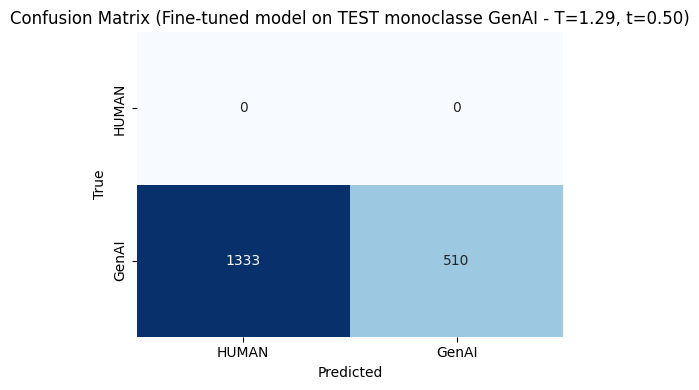


[LOG] Evaluation of fine-tuned model on TEST — samples: 1843
Accuracy (=Recall GenAI): 0.2767
Precision (GenAI): 1.0000
Recall (GenAI): 0.2767


In [ ]:
# EVALUATE FINE-TUNED MODEL ON THE ITALIAN TEST SET
TEST_EVAL_CSV = TEST_CSV
assert os.path.exists(TEST_EVAL_CSV)

# Reuse the vocabulary from the initial training
base_vocab = vocab

df_eval = pd.read_csv(TEST_EVAL_CSV)
print(f"[LOG] Evaluating fine-tuned model on TEST_EVAL: {TEST_EVAL_CSV} ({len(df_eval)} righe)")
print("[LOG] Distribuzione label:")
print(df_eval["label"].value_counts().sort_index().to_string())

# Evaluate using the temperature T from initial evaluation and a fixed threshold of 0.5
rep_test_finetuned, cm_test_finetuned, n_test_finetuned = evaluate_csv(
    model, TEST_EVAL_CSV, vocab=base_vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T, threshold=0.5,
    plot_cm=True, title_suffix=f"(Fine-tuned model on TEST monoclasse GenAI - T={T:.2f}, t=0.50)"
)

# Sanity check: The sum of the confusion matrix must equal the number of samples
assert cm_test_finetuned.sum() == n_test_finetuned, f"Did not see all samples in TEST: seen {cm_test_finetuned.sum()} out of {n_test_finetuned}"
print(f"\n[LOG] Evaluation of fine-tuned model on TEST — samples: {n_test_finetuned}")

# Print metrics relevant to the monoclass GenAI dataset
# In a monoclass GenAI dataset, Accuracy is equivalent to Recall for the GenAI class
recall_genai_finetuned = cm_test_finetuned[1,1] / n_test_finetuned if n_test_finetuned > 0 else 0.0
# Precision for GenAI is TP / (TP + FP)
precision_genai_finetuned = cm_test_finetuned[1,1] / max(1, cm_test_finetuned[:,1].sum())

print(f"Accuracy (=Recall GenAI): {recall_genai_finetuned:.4f}")
print(f"Precision (GenAI): {precision_genai_finetuned:.4f}")
print(f"Recall (GenAI): {recall_genai_finetuned:.4f}")

In [ ]:
# Generate detailed predictions for the TEST set with the fine-tuned model
test_ds_for_csv = TextDataset(TEST_EVAL_CSV, vocab=vocab)
test_dl = make_loader(test_ds_for_csv, finetune_global_var["batch_size"], shuffle=False)

probs, preds = [], []
model.eval()
with torch.inference_mode():
    for bx, _ in test_dl:
        # Get the probability of the GenAI class (index 1) using the previously calculated temperature
        p1 = F.softmax(model(bx.to(device))/T, dim=1)[:,1].cpu().numpy()
        probs.extend(p1.tolist())
        # Use the fixed threshold of 0.5 for binary prediction
        preds.extend((np.array(p1) >= 0.5).astype(int).tolist())

df_src = pd.read_csv(TEST_EVAL_CSV)
map_lab = {0:"HUMAN", 1:"GenAI"}
df_out = pd.DataFrame({
    **({"id": df_src["id"]} if "id" in df_src.columns else {}),
    **({"topic": df_src["topic"]} if "topic" in df_src.columns else {}),
    "text": df_src["text"].astype(str),
    "true_id": df_src["label"].astype(int),
    "pred_id": np.array(preds, dtype=int),
    "prob_genai": np.array(probs, dtype=float)
})
df_out["true"] = df_out["true_id"].map(map_lab)
df_out["pred"] = df_out["pred_id"].map(map_lab)
df_out["correct"] = np.where(df_out["true_id"]==df_out["pred_id"], "✓", "✗")

# Order the DataFrame: errors first, then by probability of GenAI (descending) within errors/correct
df_view = df_out.copy()
df_view["err_rank"] = (df_view["correct"]=="✓").astype(int) # 0 for error, 1 for correct
# Sort by error rank (errors first), then by probability of GenAI (descending)
df_view = df_view.sort_values(["err_rank","prob_genai"], ascending=[True, False]).drop(columns=["err_rank"])

# Display the head of the predictions DataFrame
pd.set_option("display.max_colwidth", 160)
cols = [c for c in ["id","topic"] if c in df_view.columns] + ["text","true","pred","prob_genai","correct"]
print("[INFO] Prime 30 righe predizioni su TEST (errori in alto).\n")
display(df_view[cols].head(30))

# Save the complete predictions to a CSV file
fname = f"predictions_TEST_finetuned_T{T:.2f}_t{0.5:.2f}.csv"
save_path = os.path.join(BASE, fname)
df_view.to_csv(save_path, index=False, encoding="utf-8")
print("[LOG] File predizioni TEST (fine-tuned) salvato in:", save_path, "| righe:", len(df_view))

# Display the head of a DataFrame containing only the errors
df_errors = df_view[df_view["correct"]=="✗"][cols]
print(f"\n[INFO] Errori totali su TEST (fine-tuned): {len(df_errors)}\n")
display(df_errors.head(20))

[INFO] Prime 30 righe predizioni su TEST (errori in alto).



,id,text,true,pred,prob_genai,correct
1130,e2a46b15-48bc-4670-8f41-bc0d79d26de0,Negli Stati Uniti si è scatenato un vespaio di polemiche in seguito alla recente pubblicazione di un rapporto indipendente sulle “ molestie ” verificatesi n...,GenAI,HUMAN,0.499757,✗
1583,e5165c21-1e85-409d-9199-229ec1c4a707,"L'Unione Europea (UE) ha recentemente annunciato la sua decisione di porre fine alle frontiere all'interno dell'area Schengen, consentendo ai migranti e rif...",GenAI,HUMAN,0.498556,✗
505,01ce6717-8b7d-4970-8e76-d60f5082793d,"In Turchia, un giornalista rischia il carcere con l'accusa di aver insultato il presidente Recep Tayyip Erdoğan. L'articolo del New York Times riporta che S...",GenAI,HUMAN,0.498375,✗
494,080ccdeb-21ac-4b64-b15c-05aae67e5c16,"La Cina è conosciuta per la sua avanzata tecnologia e innovazione, ma nulla può essere più impressionante della recente apertura del primo sistema di metrop...",GenAI,HUMAN,0.498268,✗
1576,3decdd8c-e316-4cc0-b666-94f667e35f64,"La notizia che il licenziamento diventerà più facile è stata accolta con gioia da Cisl e Uil, le due principali confederazioni sindacali italiane. Secondo i...",GenAI,HUMAN,0.498205,✗
1827,abc98dc1-2ba2-46de-876f-e7d962dc635b,"Si continua a parlare del grave gesto di inciviltà che è avvenuto a Milano, in via Montenapoleone , dove un uomo è stato insultato e spintonato , davanti a ...",GenAI,HUMAN,0.497355,✗
733,21df0072-01f0-41bb-8601-d1b426b402f8,"La famiglia reale britannica è stata coinvolta in uno scandalo a seguito della pubblicazione di foto del battesimo del principe Louis. Le immagini, che sono...",GenAI,HUMAN,0.496346,✗
441,a3a70a55-6ba1-4a5c-968f-74c93a7a94ee,I Ricchi Ragazzi di Russia sono un fenomeno che ha attirato l'attenzione dei media in tutto il mondo negli ultimi anni. Si tratta principalmente di giovani ...,GenAI,HUMAN,0.496328,✗
756,98b9679e-3cf4-4820-9c0b-0eed90923530,"Si lo so…ormai io non faccio parte più di quelle mani che colorano i tuoi giorni. Ma se vuoi, sai posso restare in disparte io saprò di certo poi rischiarar...",GenAI,HUMAN,0.496063,✗
956,4bc64cbe-68fa-4e0d-8d62-588bcb09619c,"Sarà il giovane venezuelano Diego Matheuz a dirigere il concerto inaugurale della nuova stagione dell'Orchestra Mozart, il complesso «giovanile» ma non nece...",GenAI,HUMAN,0.495987,✗


[LOG] File predizioni TEST (fine-tuned) salvato in: /content/drive/MyDrive/TESI-Classificazione/MIO/predictions_TEST_finetuned_T1.29_t0.50.csv | righe: 1843

[INFO] Errori totali su TEST (fine-tuned): 1333



,id,text,true,pred,prob_genai,correct
1130,e2a46b15-48bc-4670-8f41-bc0d79d26de0,Negli Stati Uniti si è scatenato un vespaio di polemiche in seguito alla recente pubblicazione di un rapporto indipendente sulle “ molestie ” verificatesi n...,GenAI,HUMAN,0.499757,✗
1583,e5165c21-1e85-409d-9199-229ec1c4a707,"L'Unione Europea (UE) ha recentemente annunciato la sua decisione di porre fine alle frontiere all'interno dell'area Schengen, consentendo ai migranti e rif...",GenAI,HUMAN,0.498556,✗
505,01ce6717-8b7d-4970-8e76-d60f5082793d,"In Turchia, un giornalista rischia il carcere con l'accusa di aver insultato il presidente Recep Tayyip Erdoğan. L'articolo del New York Times riporta che S...",GenAI,HUMAN,0.498375,✗
494,080ccdeb-21ac-4b64-b15c-05aae67e5c16,"La Cina è conosciuta per la sua avanzata tecnologia e innovazione, ma nulla può essere più impressionante della recente apertura del primo sistema di metrop...",GenAI,HUMAN,0.498268,✗
1576,3decdd8c-e316-4cc0-b666-94f667e35f64,"La notizia che il licenziamento diventerà più facile è stata accolta con gioia da Cisl e Uil, le due principali confederazioni sindacali italiane. Secondo i...",GenAI,HUMAN,0.498205,✗
1827,abc98dc1-2ba2-46de-876f-e7d962dc635b,"Si continua a parlare del grave gesto di inciviltà che è avvenuto a Milano, in via Montenapoleone , dove un uomo è stato insultato e spintonato , davanti a ...",GenAI,HUMAN,0.497355,✗
733,21df0072-01f0-41bb-8601-d1b426b402f8,"La famiglia reale britannica è stata coinvolta in uno scandalo a seguito della pubblicazione di foto del battesimo del principe Louis. Le immagini, che sono...",GenAI,HUMAN,0.496346,✗
441,a3a70a55-6ba1-4a5c-968f-74c93a7a94ee,I Ricchi Ragazzi di Russia sono un fenomeno che ha attirato l'attenzione dei media in tutto il mondo negli ultimi anni. Si tratta principalmente di giovani ...,GenAI,HUMAN,0.496328,✗
756,98b9679e-3cf4-4820-9c0b-0eed90923530,"Si lo so…ormai io non faccio parte più di quelle mani che colorano i tuoi giorni. Ma se vuoi, sai posso restare in disparte io saprò di certo poi rischiarar...",GenAI,HUMAN,0.496063,✗
956,4bc64cbe-68fa-4e0d-8d62-588bcb09619c,"Sarà il giovane venezuelano Diego Matheuz a dirigere il concerto inaugurale della nuova stagione dell'Orchestra Mozart, il complesso «giovanile» ma non nece...",GenAI,HUMAN,0.495987,✗


In [ ]:
# Use the existing Italian test dataset (monoclass GenAI) for fine-tuning
FINETUNE_TRAIN_CSV = TEST_CSV
FINETUNE_VAL_CSV = TEST_CSV # Using the same monoclass dataset for both train and val for fine-tuning

assert os.path.exists(FINETUNE_TRAIN_CSV), f"Fine-tune train file not found at: {FINETUNE_TRAIN_CSV}"
assert os.path.exists(FINETUNE_VAL_CSV), f"Fine-tune val file not found at: {FINETUNE_VAL_CSV}"

# Create PyTorch Datasets for fine-tuning
# Use the same vocabulary from the initial training
finetune_train_ds = TextDataset(FINETUNE_TRAIN_CSV, vocab=vocab)
finetune_val_ds = TextDataset(FINETUNE_VAL_CSV, vocab=vocab)

print(f"[LOG] Fine-tune Train Dataset: {len(finetune_train_ds)} samples")
print(f"[LOG] Fine-tune Val Dataset: {len(finetune_val_ds)} samples")

# Create DataLoaders for fine-tuning
finetune_train_loader = make_loader(finetune_train_ds, finetune_global_var["batch_size"], shuffle=True)
finetune_val_loader = make_loader(finetune_val_ds, finetune_global_var["batch_size"], shuffle=False)

print(f"[LOG] Fine-tune Train DataLoader: {len(finetune_train_loader)} batches")
print(f"[LOG] Fine-tune Val DataLoader: {len(finetune_val_loader)} batches")

# Recalculate class weights using the fine-tuning dataset (which is monoclass GenAI)
# Since it's monoclass, class weights will not be meaningful for balancing,
# but we recalculate for completeness using the available data.
# Access labels from the Dataset object to avoid reloading the CSV
y_finetune_train = np.array(finetune_train_ds.labels)


cnt_finetune = Counter(y_finetune_train)
tot_finetune = int(sum(cnt_finetune.values()))
n0_finetune, n1_finetune = int(cnt_finetune.get(0, 0)), int(cnt_finetune.get(1, 0))

if n0_finetune == 0 or n1_finetune == 0:
    print("[LOG] Fine-tune dataset is monoclass → no meaningful class weights for balancing.")
    class_weights_finetune = None
else:
    w0_finetune, w1_finetune = np.clip([tot_finetune / max(1, n0_finetune), tot_finetune / max(1, n1_finetune)], 0.5, 5.0)
    class_weights_finetune = torch.tensor([w0_finetune, w1_finetune], dtype=torch.float, device=device)
    print(f"[LOG] Fine-tune Class weights (clipped): w0={w0_finetune:.3f}, w1={w1_finetune:.3f}")

# Redefine the loss function with new class weights (if any) and fine-tuning label smoothing
loss_fn_finetune = nn.CrossEntropyLoss(
    weight=class_weights_finetune,
    label_smoothing=finetune_global_var["label_smoothing"]
)

# Redefine the optimizer for fine-tuning
adamw_finetune_kwargs = dict(lr=finetune_global_var["learning_rate"], weight_decay=finetune_global_var["weight_decay"])
try:
    optimizer_finetune = torch.optim.AdamW(model.parameters(), fused=True, **adamw_finetune_kwargs)
except TypeError:
    optimizer_finetune = torch.optim.AdamW(model.parameters(), **adamw_finetune_kwargs)

# Recalculate scheduler steps based on fine-tuning loader and epochs
steps_per_epoch_finetune = max(1, len(finetune_train_loader))
total_steps_finetune = steps_per_epoch_finetune * finetune_global_var["epochs"]
warmup_ratio_finetune = finetune_global_var["warmup_ratio"] # Use the same warmup ratio
warmup_steps_finetune = max(1, int(warmup_ratio_finetune * total_steps_finetune))

def lr_lambda_finetune(step):
    if step < warmup_steps_finetune:
        return float(step) / float(max(1, warmup_steps_finetune))
    prog = float(step - warmup_steps_finetune) / float(max(1, total_steps_finetune - warmup_steps_finetune))
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * prog)))

# Redefine the scheduler for fine-tuning
scheduler_finetune = torch.optim.lr_scheduler.LambdaLR(optimizer_finetune, lr_lambda_finetune)

# Start fine-tuning
print("[LOG] Starting fine-tuning...")
# Assuming train_amp_with_valcurve is defined and accepts the necessary parameters
# Pass the fine-tuning specific optimizer, loss function, and scheduler
history_finetune = train_amp_with_valcurve(
    model,
    finetune_train_loader,
    finetune_val_loader,
    finetune_global_var["epochs"]
)

print("[LOG] Fine-tuning completed.")

[LOG] Fine-tune Train Dataset: 1843 samples
[LOG] Fine-tune Val Dataset: 1843 samples
[LOG] Fine-tune Train DataLoader: 10 batches
[LOG] Fine-tune Val DataLoader: 10 batches
[LOG] Fine-tune dataset is monoclass → no meaningful class weights for balancing.
[LOG] Starting fine-tuning...


/tmp/ipython-input-2394475225.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = torch.cuda.amp.GradScaler(enabled=use_scaler)


Epoch 1/5 [train]:   0%|          | 0/10 [00:00<?, ?batch/s]

[LOG] Ep1: train_loss=0.6071 | val_loss=1.1783


Epoch 2/5 [train]:   0%|          | 0/10 [00:00<?, ?batch/s]

[LOG] Ep2: train_loss=0.6027 | val_loss=1.1782


Epoch 3/5 [train]:   0%|          | 0/10 [00:00<?, ?batch/s]

[LOG] Ep3: train_loss=0.5999 | val_loss=1.1760


Epoch 4/5 [train]:   0%|          | 0/10 [00:00<?, ?batch/s]

[LOG] Ep4: train_loss=0.5979 | val_loss=1.1764


Epoch 5/5 [train]:   0%|          | 0/10 [00:00<?, ?batch/s]

[LOG] Ep5: train_loss=0.6076 | val_loss=1.1751
[LOG] Fine-tuning completed.


[LOG] Evaluating fine-tuned model on TEST_EVAL: /content/drive/MyDrive/TESI-Classificazione/MIO/it_dev_full.csv (1843 righe)
[LOG] Distribuzione label:
label
1    1843


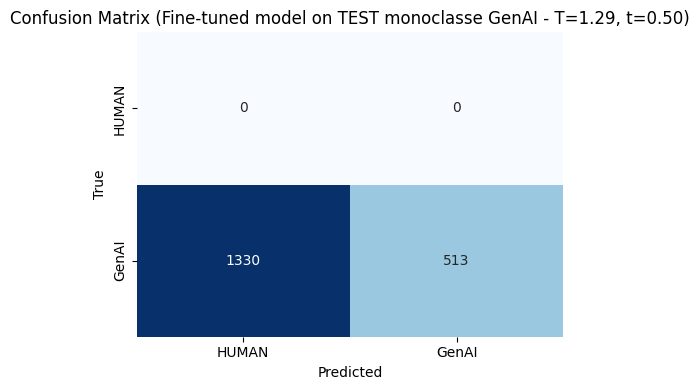


[LOG] Evaluation of fine-tuned model on TEST — samples: 1843
Accuracy (=Recall GenAI): 0.2784
Precision (GenAI): 1.0000
Recall (GenAI): 0.2784


In [ ]:
# EVALUATE FINE-TUNED MODEL ON THE ITALIAN TEST SET
TEST_EVAL_CSV = TEST_CSV
assert os.path.exists(TEST_EVAL_CSV)

# Reuse the vocabulary from the initial training
base_vocab = vocab

df_eval = pd.read_csv(TEST_EVAL_CSV)
print(f"[LOG] Evaluating fine-tuned model on TEST_EVAL: {TEST_EVAL_CSV} ({len(df_eval)} righe)")
print("[LOG] Distribuzione label:")
print(df_eval["label"].value_counts().sort_index().to_string())

# Evaluate using the temperature T from initial evaluation and a fixed threshold of 0.5
rep_test_finetuned, cm_test_finetuned, n_test_finetuned = evaluate_csv(
    model, TEST_EVAL_CSV, vocab=base_vocab,
    label_names=("HUMAN","GenAI"),
    temperature=T, threshold=0.5,
    plot_cm=True, title_suffix=f"(Fine-tuned model on TEST monoclasse GenAI - T={T:.2f}, t=0.50)"
)

# Sanity check: The sum of the confusion matrix must equal the number of samples
assert cm_test_finetuned.sum() == n_test_finetuned, f"Did not see all samples in TEST: seen {cm_test_finetuned.sum()} out of {n_test_finetuned}"
print(f"\n[LOG] Evaluation of fine-tuned model on TEST — samples: {n_test_finetuned}")

# Print metrics relevant to the monoclass GenAI dataset
# In a monoclass GenAI dataset, Accuracy is equivalent to Recall for the GenAI class
recall_genai_finetuned = cm_test_finetuned[1,1] / n_test_finetuned if n_test_finetuned > 0 else 0.0
# Precision for GenAI is TP / (TP + FP)
precision_genai_finetuned = cm_test_finetuned[1,1] / max(1, cm_test_finetuned[:,1].sum())

print(f"Accuracy (=Recall GenAI): {recall_genai_finetuned:.4f}")
print(f"Precision (GenAI): {precision_genai_finetuned:.4f}")
print(f"Recall (GenAI): {recall_genai_finetuned:.4f}")

[LOG] Evaluating fine-tuned model on TEST_EVAL with intermediate threshold: /content/drive/MyDrive/TESI-Classificazione/MIO/it_dev_full.csv (1843 righe)
[LOG] Distribuzione label:
label
1    1843

--- Evaluating with threshold: 0.20 ---


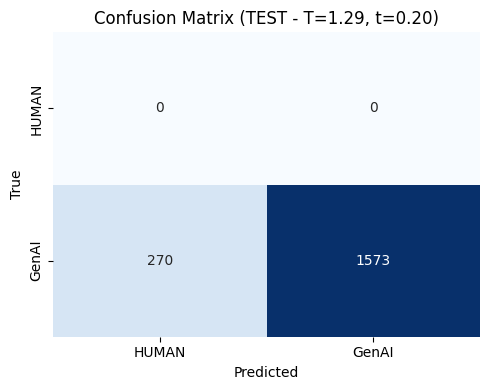


[LOG] Evaluation on TEST with threshold (0.20) — samples: 1843
Accuracy: 0.8535
Precision (GenAI): 1.0000 | Recall (GenAI): 0.8535


In [ ]:
# Evaluate fine-tuned model on the Italian test set with intermediate thresholds
TEST_EVAL_CSV = TEST_CSV
assert os.path.exists(TEST_EVAL_CSV)

# Reuse the vocabulary from the initial training
base_vocab = vocab

df_eval = pd.read_csv(TEST_EVAL_CSV)
print(f"[LOG] Evaluating fine-tuned model on TEST_EVAL with intermediate threshold: {TEST_EVAL_CSV} ({len(df_eval)} righe)")
print("[LOG] Distribuzione label:")
print(df_eval["label"].value_counts().sort_index().to_string())

# Define the single intermediate threshold to test
intermediate_thresholds = [0.20]

for threshold in intermediate_thresholds:
    print(f"\n--- Evaluating with threshold: {threshold:.2f} ---")
    rep_test_intermediate, cm_test_intermediate, n_test_intermediate = evaluate_csv(
        model, TEST_EVAL_CSV, vocab=base_vocab,
        label_names=("HUMAN","GenAI"),
        temperature=T, threshold=threshold, # Use the intermediate threshold
        plot_cm=True, title_suffix=f"(TEST - T={T:.2f}, t={threshold:.2f})"
    )

    # Sanity check: The sum of the confusion matrix must equal the number of samples
    assert cm_test_intermediate.sum() == n_test_intermediate, f"Did not see all samples in TEST: seen {cm_test_intermediate.sum()} out of {n_test_intermediate}"
    print(f"\n[LOG] Evaluation on TEST with threshold ({threshold:.2f}) — samples: {n_test_intermediate}")

    # Print metrics relevant to the monoclass GenAI dataset
    print(f"Accuracy: {rep_test_intermediate['accuracy']:.4f}")
    if 'GenAI' in rep_test_intermediate:
        print(f"Precision (GenAI): {rep_test_intermediate['GenAI']['precision']:.4f} | Recall (GenAI): {rep_test_intermediate['GenAI']['recall']:.4f}")
    else:
        print("Metrics for GenAI class not available in the report.")

In [ ]:
# Generate detailed predictions for the TEST set with the fine-tuned model
test_ds_for_csv = TextDataset(TEST_EVAL_CSV, vocab=vocab)
test_dl = make_loader(test_ds_for_csv, finetune_global_var["batch_size"], shuffle=False)

probs, preds = [], []
model.eval()
with torch.inference_mode():
    for bx, _ in test_dl:
        # Get the probability of the GenAI class (index 1) using the previously calculated temperature
        p1 = F.softmax(model(bx.to(device))/T, dim=1)[:,1].cpu().numpy()
        probs.extend(p1.tolist())
        # Use the fixed threshold of 0.5 for binary prediction
        preds.extend((np.array(p1) >= 0.5).astype(int).tolist())

df_src = pd.read_csv(TEST_EVAL_CSV)
map_lab = {0:"HUMAN", 1:"GenAI"}
df_out = pd.DataFrame({
    **({"id": df_src["id"]} if "id" in df_src.columns else {}),
    **({"topic": df_src["topic"]} if "topic" in df_src.columns else {}),
    "text": df_src["text"].astype(str),
    "true_id": df_src["label"].astype(int),
    "pred_id": np.array(preds, dtype=int),
    "prob_genai": np.array(probs, dtype=float)
})
df_out["true"] = df_out["true_id"].map(map_lab)
df_out["pred"] = df_out["pred_id"].map(map_lab)
df_out["correct"] = np.where(df_out["true_id"]==df_out["pred_id"], "✓", "✗")

# Order the DataFrame: errors first, then by probability of GenAI (descending) within errors/correct
df_view = df_out.copy()
df_view["err_rank"] = (df_view["correct"]=="✓").astype(int) # 0 for error, 1 for correct
# Sort by error rank (errors first), then by probability of GenAI (descending)
df_view = df_view.sort_values(["err_rank","prob_genai"], ascending=[True, False]).drop(columns=["err_rank"])

# Display the head of the predictions DataFrame
pd.set_option("display.max_colwidth", 160)
cols = [c for c in ["id","topic"] if c in df_view.columns] + ["text","true","pred","prob_genai","correct"]
print("[INFO] Prime 30 righe predizioni su TEST (errori in alto).\n")
display(df_view[cols].head(30))

# Save the complete predictions to a CSV file
fname = f"predictions_TEST_finetuned_T{T:.2f}_t{0.5:.2f}.csv"
save_path = os.path.join(BASE, fname)
df_view.to_csv(save_path, index=False, encoding="utf-8")
print("[LOG] File predizioni TEST (fine-tuned) salvato in:", save_path, "| righe:", len(df_view))

# Display the head of a DataFrame containing only the errors
df_errors = df_view[df_view["correct"]=="✗"][cols]
print(f"\n[INFO] Errori totali su TEST (fine-tuned): {len(df_errors)}\n")
display(df_errors.head(20))

[INFO] Prime 30 righe predizioni su TEST (errori in alto).



,id,text,true,pred,prob_genai,correct
1576,3decdd8c-e316-4cc0-b666-94f667e35f64,"La notizia che il licenziamento diventerà più facile è stata accolta con gioia da Cisl e Uil, le due principali confederazioni sindacali italiane. Secondo i...",GenAI,HUMAN,0.499805,✗
1827,abc98dc1-2ba2-46de-876f-e7d962dc635b,"Si continua a parlare del grave gesto di inciviltà che è avvenuto a Milano, in via Montenapoleone , dove un uomo è stato insultato e spintonato , davanti a ...",GenAI,HUMAN,0.499649,✗
505,01ce6717-8b7d-4970-8e76-d60f5082793d,"In Turchia, un giornalista rischia il carcere con l'accusa di aver insultato il presidente Recep Tayyip Erdoğan. L'articolo del New York Times riporta che S...",GenAI,HUMAN,0.499579,✗
756,98b9679e-3cf4-4820-9c0b-0eed90923530,"Si lo so…ormai io non faccio parte più di quelle mani che colorano i tuoi giorni. Ma se vuoi, sai posso restare in disparte io saprò di certo poi rischiarar...",GenAI,HUMAN,0.499046,✗
441,a3a70a55-6ba1-4a5c-968f-74c93a7a94ee,I Ricchi Ragazzi di Russia sono un fenomeno che ha attirato l'attenzione dei media in tutto il mondo negli ultimi anni. Si tratta principalmente di giovani ...,GenAI,HUMAN,0.498958,✗
733,21df0072-01f0-41bb-8601-d1b426b402f8,"La famiglia reale britannica è stata coinvolta in uno scandalo a seguito della pubblicazione di foto del battesimo del principe Louis. Le immagini, che sono...",GenAI,HUMAN,0.497770,✗
956,4bc64cbe-68fa-4e0d-8d62-588bcb09619c,"Sarà il giovane venezuelano Diego Matheuz a dirigere il concerto inaugurale della nuova stagione dell'Orchestra Mozart, il complesso «giovanile» ma non nece...",GenAI,HUMAN,0.497579,✗
697,b7ec4ec2-e061-426e-a918-001df4f26867,"Promemoria per chi ha programmato per l'anno prossimo una vacanza in Maremma e fa turismo culturale: a Sorano riapre la Via Cava di San Rocco, rimasta chius...",GenAI,HUMAN,0.497285,✗
1081,794b22cf-0907-41d0-9484-96b6a2219eec,"La notizia che l'Archivio Vasari è stato sequestrato dai Carabinieri ha sollevato molte polemiche in Italia. L'archivio, situato a Firenze e gestito dall'Is...",GenAI,HUMAN,0.496587,✗
1080,3351e91e-4d25-4b74-a127-fb1499b20aaa,"Audi amplia la sua nuova serie di modelli che va sotto il nome di ""e-tron"". La A1 e-tron, che la Casa dei quattro anelli presenta al Salone di Ginevra, è un...",GenAI,HUMAN,0.496379,✗


[LOG] File predizioni TEST (fine-tuned) salvato in: /content/drive/MyDrive/TESI-Classificazione/MIO/predictions_TEST_finetuned_T1.29_t0.50.csv | righe: 1843

[INFO] Errori totali su TEST (fine-tuned): 1330



,id,text,true,pred,prob_genai,correct
1576,3decdd8c-e316-4cc0-b666-94f667e35f64,"La notizia che il licenziamento diventerà più facile è stata accolta con gioia da Cisl e Uil, le due principali confederazioni sindacali italiane. Secondo i...",GenAI,HUMAN,0.499805,✗
1827,abc98dc1-2ba2-46de-876f-e7d962dc635b,"Si continua a parlare del grave gesto di inciviltà che è avvenuto a Milano, in via Montenapoleone , dove un uomo è stato insultato e spintonato , davanti a ...",GenAI,HUMAN,0.499649,✗
505,01ce6717-8b7d-4970-8e76-d60f5082793d,"In Turchia, un giornalista rischia il carcere con l'accusa di aver insultato il presidente Recep Tayyip Erdoğan. L'articolo del New York Times riporta che S...",GenAI,HUMAN,0.499579,✗
756,98b9679e-3cf4-4820-9c0b-0eed90923530,"Si lo so…ormai io non faccio parte più di quelle mani che colorano i tuoi giorni. Ma se vuoi, sai posso restare in disparte io saprò di certo poi rischiarar...",GenAI,HUMAN,0.499046,✗
441,a3a70a55-6ba1-4a5c-968f-74c93a7a94ee,I Ricchi Ragazzi di Russia sono un fenomeno che ha attirato l'attenzione dei media in tutto il mondo negli ultimi anni. Si tratta principalmente di giovani ...,GenAI,HUMAN,0.498958,✗
733,21df0072-01f0-41bb-8601-d1b426b402f8,"La famiglia reale britannica è stata coinvolta in uno scandalo a seguito della pubblicazione di foto del battesimo del principe Louis. Le immagini, che sono...",GenAI,HUMAN,0.497770,✗
956,4bc64cbe-68fa-4e0d-8d62-588bcb09619c,"Sarà il giovane venezuelano Diego Matheuz a dirigere il concerto inaugurale della nuova stagione dell'Orchestra Mozart, il complesso «giovanile» ma non nece...",GenAI,HUMAN,0.497579,✗
697,b7ec4ec2-e061-426e-a918-001df4f26867,"Promemoria per chi ha programmato per l'anno prossimo una vacanza in Maremma e fa turismo culturale: a Sorano riapre la Via Cava di San Rocco, rimasta chius...",GenAI,HUMAN,0.497285,✗
1081,794b22cf-0907-41d0-9484-96b6a2219eec,"La notizia che l'Archivio Vasari è stato sequestrato dai Carabinieri ha sollevato molte polemiche in Italia. L'archivio, situato a Firenze e gestito dall'Is...",GenAI,HUMAN,0.496587,✗
1080,3351e91e-4d25-4b74-a127-fb1499b20aaa,"Audi amplia la sua nuova serie di modelli che va sotto il nome di ""e-tron"". La A1 e-tron, che la Casa dei quattro anelli presenta al Salone di Ginevra, è un...",GenAI,HUMAN,0.496379,✗
